In [3]:
#Save con Nodos
import os
from keras.models import load_model
import itertools
from matplotlib import pyplot as plt
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import os, sys
dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from sklearn.utils import class_weight
import numpy as np

from evaluation import calculate_metrics
from sklearn.metrics import confusion_matrix,accuracy_score
import pandas as pd
from keras.regularizers import l2
from keras.activations import tanh
from keras.models import Sequential
from keras.layers import *
from keras.losses import categorical_crossentropy,binary_crossentropy
from keras.optimizers import SGD,Adam
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from keras import backend as K
from time import time
import random
from random import shuffle,seed
from sklearn.metrics import classification_report
import math
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler,EarlyStopping,ReduceLROnPlateau
from keras.backend import eval



In [4]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix
from sklearn.preprocessing import normalize
import time

def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    
def plot_state_matrix(cm, states,title='Transition Probabilities',cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(states))
    plt.xticks(tick_marks, states)
    plt.yticks(tick_marks, states)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.ylabel('Origin state')
    plt.xlabel('Destination state')
    plt.tight_layout()
    
def to_int(labels):
    y_true=[]
    for y in labels:
        if y=='CONFIRMED':
            y_true.append(1)
        else:
            y_true.append(0)
    return y_true

def plot_model_and_data(plot_lc, model, p_n=2000, real_lc=[] ):
    X_state = model.predict(plot_lc) #predice el estado, no el valor 
    X_state_mean = model.means_[X_state][:,0]
    X_state_cov = np.sqrt(model.covars_[X_state][:,0,0])
    if len(real_lc) != 0:
        if len(plot_lc) != len(real_lc):
            mask_nan = np.isnan(real_lc)
            aux = np.tile(np.nan, len(real_lc) )
            
            aux_lc = aux.copy()
            aux_lc[~mask_nan] = np.squeeze(plot_lc)
            plot_lc = aux_lc
            
            aux_X_state_mean = aux.copy()
            aux_X_state_mean[~mask_nan] = X_state_mean
            X_state_mean = aux_X_state_mean
            
            aux_X_state_cov = aux.copy()
            aux_X_state_cov[~mask_nan] = X_state_cov
            X_state_cov = aux_X_state_cov
    plt.figure(figsize=(14,6))
    plt.plot(plot_lc,'r.-',label="Data")
    plt.fill_between(np.arange(len(plot_lc)),
                     X_state_mean-1.96*X_state_cov,
                     X_state_mean+1.96*X_state_cov) 
    plt.plot(X_state_mean,'g*-',label="Prediccion de la media") 
    plt.legend()
    plt.title("prediccion de markov en curva")
    plt.show()
    
    plt.figure(figsize=(14,6))
    plt.plot(plot_lc[:p_n],'r.-',label="Data")
    plt.fill_between(np.arange(p_n),
                     X_state_mean[:p_n]-1.96*X_state_cov[:p_n],
                     X_state_mean[:p_n]+1.96*X_state_cov[:p_n]) 
    plt.plot(X_state_mean[:p_n],'g*-',label="Prediccion de la media") 
    plt.legend()
    plt.title("prediccion de markov zoom en curva")
    plt.show()

In [5]:
fold = "../../KOI_Data/"
df_sets = pd.read_csv(fold+"/koi_sets_unb.csv") 
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
mask_unlabeled = (df_sets["Set"] == "Unlabeled").values

df_meta = pd.read_csv(fold+"/koi_metadata.csv")
df_meta_train = df_meta[mask_train]
df_meta_test = df_meta[mask_test]
df_meta_unb = df_meta[mask_unlabeled]

kois_train=df_meta_train['KOI Name'].values
labels_train=df_meta_train['NExScI Disposition'].values
kois_val=df_meta_test['KOI Name'].values
labels_val=df_meta_test['NExScI Disposition'].values
kois_test=df_meta_unb['KOI Name'].values
labels_test=df_meta_unb['NExScI Disposition'].values


folder_fp='/work/work_teamEXOPLANET/MTF/falsos_positivos/'
folder_c='/work/work_teamEXOPLANET/MTF_gabo/'
falsos=os.listdir(folder_fp)
confirmed=os.listdir(folder_c+'confirmados')
candidates=os.listdir(folder_c+'candidatos')
#load data
x_train=[]
i=0
for koi in kois_train:
    print ("Cargando objeto", koi, 'con ientificador',i)
    if labels_train[i]=='FALSE POSITIVE':
        x_train.append(np.load(folder_fp+koi+'.npy'))
    else:
        x_train.append(np.load(folder_c+'confirmados/'+koi+'.npy'))
    i+=1
    
x_val=[]
i=0
for koi in kois_val:
    print ("Cargando objeto", koi, 'con ientificador',i)
    if labels_val[i]=='FALSE POSITIVE':
        x_val.append(np.load(folder_fp+koi+'.npy'))
    else:
        x_val.append(np.load(folder_c+'confirmados/'+koi+'.npy'))
    i+=1
    
x_test=[]
i=0
for koi in kois_test:
    print ("Cargando objeto", koi, 'con ientificador',i)
    x_test.append(np.load(folder_c+'candidatos/'+koi+'.npy'))
    i+=1
    
#all_kois=np.concatenate([np.asarray(kois_fp),np.asarray(kois_con)])
x_train=np.expand_dims(np.asarray(x_train), axis=-1)
x_val=np.expand_dims(np.asarray(x_val), axis=-1)
x_test=np.expand_dims(np.asarray(x_test), axis=-1)

print ("Objetos de entrenamiento:",x_train.shape)
print ("Objetos de validación:",x_val.shape)
print ("Objetos de testing:",x_test.shape)


Cargando objeto K01009.01 con ientificador 0
Cargando objeto K07621.01 con ientificador 1
Cargando objeto K06252.01 con ientificador 2
Cargando objeto K04162.01 con ientificador 3
Cargando objeto K00998.01 con ientificador 4
Cargando objeto K00992.01 con ientificador 5
Cargando objeto K00982.01 con ientificador 6
Cargando objeto K03924.01 con ientificador 7
Cargando objeto K07623.01 con ientificador 8
Cargando objeto K00362.01 con ientificador 9
Cargando objeto K03658.01 con ientificador 10
Cargando objeto K00993.01 con ientificador 11
Cargando objeto K00993.02 con ientificador 12
Cargando objeto K00993.03 con ientificador 13
Cargando objeto K01008.01 con ientificador 14
Cargando objeto K04224.01 con ientificador 15
Cargando objeto K04212.01 con ientificador 16
Cargando objeto K01007.01 con ientificador 17
Cargando objeto K04925.01 con ientificador 18
Cargando objeto K07625.01 con ientificador 19
Cargando objeto K04927.01 con ientificador 20
Cargando objeto K01001.01 con ientificador 2

Cargando objeto K00377.01 con ientificador 248
Cargando objeto K03084.01 con ientificador 249
Cargando objeto K01830.02 con ientificador 250
Cargando objeto K06321.01 con ientificador 251
Cargando objeto K03635.01 con ientificador 252
Cargando objeto K01994.01 con ientificador 253
Cargando objeto K04174.01 con ientificador 254
Cargando objeto K03011.01 con ientificador 255
Cargando objeto K04533.01 con ientificador 256
Cargando objeto K06323.01 con ientificador 257
Cargando objeto K03247.01 con ientificador 258
Cargando objeto K02740.01 con ientificador 259
Cargando objeto K03172.01 con ientificador 260
Cargando objeto K01114.01 con ientificador 261
Cargando objeto K02265.01 con ientificador 262
Cargando objeto K06324.01 con ientificador 263
Cargando objeto K06325.01 con ientificador 264
Cargando objeto K03795.01 con ientificador 265
Cargando objeto K01845.01 con ientificador 266
Cargando objeto K06326.01 con ientificador 267
Cargando objeto K03677.01 con ientificador 268
Cargando obje

Cargando objeto K01336.03 con ientificador 521
Cargando objeto K01319.01 con ientificador 522
Cargando objeto K03594.01 con ientificador 523
Cargando objeto K01322.01 con ientificador 524
Cargando objeto K01344.01 con ientificador 525
Cargando objeto K07683.01 con ientificador 526
Cargando objeto K04742.01 con ientificador 527
Cargando objeto K02866.01 con ientificador 528
Cargando objeto K00812.01 con ientificador 529
Cargando objeto K00812.02 con ientificador 530
Cargando objeto K00812.03 con ientificador 531
Cargando objeto K00812.04 con ientificador 532
Cargando objeto K06387.01 con ientificador 533
Cargando objeto K02210.02 con ientificador 534
Cargando objeto K06109.01 con ientificador 535
Cargando objeto K02202.01 con ientificador 536
Cargando objeto K07686.01 con ientificador 537
Cargando objeto K01768.01 con ientificador 538
Cargando objeto K04046.02 con ientificador 539
Cargando objeto K01330.01 con ientificador 540
Cargando objeto K03156.02 con ientificador 541
Cargando obje

Cargando objeto K03453.01 con ientificador 793
Cargando objeto K06474.01 con ientificador 794
Cargando objeto K06122.01 con ientificador 795
Cargando objeto K03743.01 con ientificador 796
Cargando objeto K00820.01 con ientificador 797
Cargando objeto K03290.01 con ientificador 798
Cargando objeto K01873.01 con ientificador 799
Cargando objeto K01873.02 con ientificador 800
Cargando objeto K01561.01 con ientificador 801
Cargando objeto K05108.01 con ientificador 802
Cargando objeto K04658.01 con ientificador 803
Cargando objeto K05109.01 con ientificador 804
Cargando objeto K04088.01 con ientificador 805
Cargando objeto K06477.01 con ientificador 806
Cargando objeto K03272.01 con ientificador 807
Cargando objeto K06479.01 con ientificador 808
Cargando objeto K06481.01 con ientificador 809
Cargando objeto K00404.01 con ientificador 810
Cargando objeto K01753.01 con ientificador 811
Cargando objeto K06483.01 con ientificador 812
Cargando objeto K02818.01 con ientificador 813
Cargando obje

Cargando objeto K06578.01 con ientificador 1067
Cargando objeto K07727.01 con ientificador 1068
Cargando objeto K01551.01 con ientificador 1069
Cargando objeto K03039.01 con ientificador 1070
Cargando objeto K01780.01 con ientificador 1071
Cargando objeto K03521.01 con ientificador 1072
Cargando objeto K07728.01 con ientificador 1073
Cargando objeto K00835.01 con ientificador 1074
Cargando objeto K00835.02 con ientificador 1075
Cargando objeto K06580.01 con ientificador 1076
Cargando objeto K00504.01 con ientificador 1077
Cargando objeto K06581.01 con ientificador 1078
Cargando objeto K03825.01 con ientificador 1079
Cargando objeto K05171.01 con ientificador 1080
Cargando objeto K08255.01 con ientificador 1081
Cargando objeto K05172.01 con ientificador 1082
Cargando objeto K06007.01 con ientificador 1083
Cargando objeto K03956.01 con ientificador 1084
Cargando objeto K03956.02 con ientificador 1085
Cargando objeto K03504.01 con ientificador 1086
Cargando objeto K06009.01 con ientificad

Cargando objeto K06650.01 con ientificador 1390
Cargando objeto K06651.01 con ientificador 1391
Cargando objeto K08114.01 con ientificador 1392
Cargando objeto K06652.01 con ientificador 1393
Cargando objeto K02646.01 con ientificador 1394
Cargando objeto K03948.01 con ientificador 1395
Cargando objeto K06654.01 con ientificador 1396
Cargando objeto K02100.01 con ientificador 1397
Cargando objeto K01013.01 con ientificador 1398
Cargando objeto K01684.01 con ientificador 1399
Cargando objeto K06655.01 con ientificador 1400
Cargando objeto K06656.01 con ientificador 1401
Cargando objeto K08115.01 con ientificador 1402
Cargando objeto K03972.01 con ientificador 1403
Cargando objeto K01799.01 con ientificador 1404
Cargando objeto K03616.01 con ientificador 1405
Cargando objeto K01059.01 con ientificador 1406
Cargando objeto K06658.01 con ientificador 1407
Cargando objeto K00846.01 con ientificador 1408
Cargando objeto K00658.01 con ientificador 1409
Cargando objeto K00658.02 con ientificad

Cargando objeto K06743.01 con ientificador 1695
Cargando objeto K01691.01 con ientificador 1696
Cargando objeto K03270.01 con ientificador 1697
Cargando objeto K05305.01 con ientificador 1698
Cargando objeto K02737.01 con ientificador 1699
Cargando objeto K03306.01 con ientificador 1700
Cargando objeto K05307.01 con ientificador 1701
Cargando objeto K01692.01 con ientificador 1702
Cargando objeto K01692.02 con ientificador 1703
Cargando objeto K01225.01 con ientificador 1704
Cargando objeto K07571.01 con ientificador 1705
Cargando objeto K06747.01 con ientificador 1706
Cargando objeto K01227.01 con ientificador 1707
Cargando objeto K06748.01 con ientificador 1708
Cargando objeto K02738.01 con ientificador 1709
Cargando objeto K05308.01 con ientificador 1710
Cargando objeto K02262.01 con ientificador 1711
Cargando objeto K01232.01 con ientificador 1712
Cargando objeto K01232.02 con ientificador 1713
Cargando objeto K02005.01 con ientificador 1714
Cargando objeto K00561.01 con ientificad

Cargando objeto K03610.01 con ientificador 2024
Cargando objeto K02487.01 con ientificador 2025
Cargando objeto K06848.01 con ientificador 2026
Cargando objeto K07583.01 con ientificador 2027
Cargando objeto K01618.01 con ientificador 2028
Cargando objeto K03056.01 con ientificador 2029
Cargando objeto K00238.01 con ientificador 2030
Cargando objeto K00238.02 con ientificador 2031
Cargando objeto K03775.01 con ientificador 2032
Cargando objeto K01350.01 con ientificador 2033
Cargando objeto K01700.01 con ientificador 2034
Cargando objeto K00019.01 con ientificador 2035
Cargando objeto K02292.01 con ientificador 2036
Cargando objeto K06034.01 con ientificador 2037
Cargando objeto K02051.01 con ientificador 2038
Cargando objeto K01961.01 con ientificador 2039
Cargando objeto K00456.01 con ientificador 2040
Cargando objeto K00456.02 con ientificador 2041
Cargando objeto K00876.01 con ientificador 2042
Cargando objeto K01979.01 con ientificador 2043
Cargando objeto K00674.01 con ientificad

Cargando objeto K06945.01 con ientificador 2351
Cargando objeto K00459.01 con ientificador 2352
Cargando objeto K00459.02 con ientificador 2353
Cargando objeto K03846.01 con ientificador 2354
Cargando objeto K06947.01 con ientificador 2355
Cargando objeto K03219.01 con ientificador 2356
Cargando objeto K03536.01 con ientificador 2357
Cargando objeto K02594.01 con ientificador 2358
Cargando objeto K02328.01 con ientificador 2359
Cargando objeto K06949.01 con ientificador 2360
Cargando objeto K00316.02 con ientificador 2361
Cargando objeto K06950.01 con ientificador 2362
Cargando objeto K00569.01 con ientificador 2363
Cargando objeto K00569.02 con ientificador 2364
Cargando objeto K01569.01 con ientificador 2365
Cargando objeto K06951.01 con ientificador 2366
Cargando objeto K08151.01 con ientificador 2367
Cargando objeto K06952.01 con ientificador 2368
Cargando objeto K02352.01 con ientificador 2369
Cargando objeto K00517.01 con ientificador 2370
Cargando objeto K06953.01 con ientificad

Cargando objeto K02362.01 con ientificador 2681
Cargando objeto K02362.02 con ientificador 2682
Cargando objeto K07048.01 con ientificador 2683
Cargando objeto K00912.01 con ientificador 2684
Cargando objeto K00912.02 con ientificador 2685
Cargando objeto K02094.02 con ientificador 2686
Cargando objeto K05527.01 con ientificador 2687
Cargando objeto K04299.01 con ientificador 2688
Cargando objeto K07890.01 con ientificador 2689
Cargando objeto K07049.01 con ientificador 2690
Cargando objeto K05529.01 con ientificador 2691
Cargando objeto K06181.01 con ientificador 2692
Cargando objeto K07050.01 con ientificador 2693
Cargando objeto K04093.01 con ientificador 2694
Cargando objeto K04083.01 con ientificador 2695
Cargando objeto K07051.01 con ientificador 2696
Cargando objeto K01975.01 con ientificador 2697
Cargando objeto K02466.01 con ientificador 2698
Cargando objeto K02466.02 con ientificador 2699
Cargando objeto K00913.01 con ientificador 2700
Cargando objeto K07893.01 con ientificad

Cargando objeto K07127.01 con ientificador 3012
Cargando objeto K03799.01 con ientificador 3013
Cargando objeto K05607.01 con ientificador 3014
Cargando objeto K00702.01 con ientificador 3015
Cargando objeto K03008.01 con ientificador 3016
Cargando objeto K00023.01 con ientificador 3017
Cargando objeto K02257.01 con ientificador 3018
Cargando objeto K04198.01 con ientificador 3019
Cargando objeto K08175.01 con ientificador 3020
Cargando objeto K00583.01 con ientificador 3021
Cargando objeto K02981.01 con ientificador 3022
Cargando objeto K00926.01 con ientificador 3023
Cargando objeto K07922.01 con ientificador 3024
Cargando objeto K07128.01 con ientificador 3025
Cargando objeto K03249.01 con ientificador 3026
Cargando objeto K01631.01 con ientificador 3027
Cargando objeto K08176.01 con ientificador 3028
Cargando objeto K03393.01 con ientificador 3029
Cargando objeto K04052.01 con ientificador 3030
Cargando objeto K02716.01 con ientificador 3031
Cargando objeto K07130.01 con ientificad

Cargando objeto K00022.01 con ientificador 3339
Cargando objeto K01451.01 con ientificador 3340
Cargando objeto K07206.01 con ientificador 3341
Cargando objeto K03618.01 con ientificador 3342
Cargando objeto K02892.01 con ientificador 3343
Cargando objeto K00527.01 con ientificador 3344
Cargando objeto K07207.01 con ientificador 3345
Cargando objeto K02912.01 con ientificador 3346
Cargando objeto K04172.01 con ientificador 3347
Cargando objeto K07210.01 con ientificador 3348
Cargando objeto K07210.02 con ientificador 3349
Cargando objeto K04177.01 con ientificador 3350
Cargando objeto K01504.01 con ientificador 3351
Cargando objeto K07211.01 con ientificador 3352
Cargando objeto K00324.01 con ientificador 3353
Cargando objeto K04262.01 con ientificador 3354
Cargando objeto K02152.01 con ientificador 3355
Cargando objeto K02946.01 con ientificador 3356
Cargando objeto K01457.01 con ientificador 3357
Cargando objeto K07214.01 con ientificador 3358
Cargando objeto K02049.01 con ientificad

Cargando objeto K01604.01 con ientificador 3665
Cargando objeto K04835.01 con ientificador 3666
Cargando objeto K01608.01 con ientificador 3667
Cargando objeto K01608.02 con ientificador 3668
Cargando objeto K03234.01 con ientificador 3669
Cargando objeto K07280.01 con ientificador 3670
Cargando objeto K02891.01 con ientificador 3671
Cargando objeto K02602.01 con ientificador 3672
Cargando objeto K02628.01 con ientificador 3673
Cargando objeto K08194.01 con ientificador 3674
Cargando objeto K08195.01 con ientificador 3675
Cargando objeto K01722.01 con ientificador 3676
Cargando objeto K08196.01 con ientificador 3677
Cargando objeto K03921.01 con ientificador 3678
Cargando objeto K04034.02 con ientificador 3679
Cargando objeto K07985.01 con ientificador 3680
Cargando objeto K02476.01 con ientificador 3681
Cargando objeto K07284.01 con ientificador 3682
Cargando objeto K01823.01 con ientificador 3683
Cargando objeto K07285.01 con ientificador 3684
Cargando objeto K03839.01 con ientificad

Cargando objeto K07340.01 con ientificador 3921
Cargando objeto K01294.01 con ientificador 3922
Cargando objeto K07341.01 con ientificador 3923
Cargando objeto K04214.01 con ientificador 3924
Cargando objeto K05804.01 con ientificador 3925
Cargando objeto K05805.01 con ientificador 3926
Cargando objeto K00338.01 con ientificador 3927
Cargando objeto K07342.01 con ientificador 3928
Cargando objeto K03059.01 con ientificador 3929
Cargando objeto K00534.01 con ientificador 3930
Cargando objeto K00534.02 con ientificador 3931
Cargando objeto K00158.01 con ientificador 3932
Cargando objeto K07343.01 con ientificador 3933
Cargando objeto K00475.02 con ientificador 3934
Cargando objeto K03807.01 con ientificador 3935
Cargando objeto K00748.01 con ientificador 3936
Cargando objeto K07344.01 con ientificador 3937
Cargando objeto K01314.01 con ientificador 3938
Cargando objeto K08293.01 con ientificador 3939
Cargando objeto K00275.01 con ientificador 3940
Cargando objeto K01308.01 con ientificad

Cargando objeto K07422.01 con ientificador 4242
Cargando objeto K07423.01 con ientificador 4243
Cargando objeto K07424.01 con ientificador 4244
Cargando objeto K02460.01 con ientificador 4245
Cargando objeto K07425.01 con ientificador 4246
Cargando objeto K03717.01 con ientificador 4247
Cargando objeto K03346.01 con ientificador 4248
Cargando objeto K02994.01 con ientificador 4249
Cargando objeto K03553.01 con ientificador 4250
Cargando objeto K00107.01 con ientificador 4251
Cargando objeto K07428.01 con ientificador 4252
Cargando objeto K07429.01 con ientificador 4253
Cargando objeto K06236.01 con ientificador 4254
Cargando objeto K01972.02 con ientificador 4255
Cargando objeto K02672.01 con ientificador 4256
Cargando objeto K02672.02 con ientificador 4257
Cargando objeto K01425.01 con ientificador 4258
Cargando objeto K02816.01 con ientificador 4259
Cargando objeto K04622.01 con ientificador 4260
Cargando objeto K07431.01 con ientificador 4261
Cargando objeto K00241.01 con ientificad

Cargando objeto K02996.01 con ientificador 4558
Cargando objeto K07507.01 con ientificador 4559
Cargando objeto K02888.01 con ientificador 4560
Cargando objeto K00265.01 con ientificador 4561
Cargando objeto K03261.01 con ientificador 4562
Cargando objeto K03262.01 con ientificador 4563
Cargando objeto K02072.01 con ientificador 4564
Cargando objeto K02218.01 con ientificador 4565
Cargando objeto K02218.02 con ientificador 4566
Cargando objeto K00546.01 con ientificador 4567
Cargando objeto K00484.01 con ientificador 4568
Cargando objeto K01502.01 con ientificador 4569
Cargando objeto K03746.01 con ientificador 4570
Cargando objeto K01487.01 con ientificador 4571
Cargando objeto K00784.02 con ientificador 4572
Cargando objeto K03282.01 con ientificador 4573
Cargando objeto K00623.01 con ientificador 4574
Cargando objeto K00623.02 con ientificador 4575
Cargando objeto K00623.03 con ientificador 4576
Cargando objeto K00623.04 con ientificador 4577
Cargando objeto K08234.01 con ientificad

Cargando objeto K00969.01 con ientificador 185
Cargando objeto K02013.01 con ientificador 186
Cargando objeto K03912.01 con ientificador 187
Cargando objeto K02731.01 con ientificador 188
Cargando objeto K02239.01 con ientificador 189
Cargando objeto K06386.01 con ientificador 190
Cargando objeto K01339.01 con ientificador 191
Cargando objeto K04033.01 con ientificador 192
Cargando objeto K07684.01 con ientificador 193
Cargando objeto K02210.01 con ientificador 194
Cargando objeto K00281.01 con ientificador 195
Cargando objeto K01791.01 con ientificador 196
Cargando objeto K05041.01 con ientificador 197
Cargando objeto K03880.01 con ientificador 198
Cargando objeto K06388.01 con ientificador 199
Cargando objeto K04046.01 con ientificador 200
Cargando objeto K01330.02 con ientificador 201
Cargando objeto K03156.03 con ientificador 202
Cargando objeto K01334.02 con ientificador 203
Cargando objeto K06389.01 con ientificador 204
Cargando objeto K03678.01 con ientificador 205
Cargando obje

Cargando objeto K04726.01 con ientificador 504
Cargando objeto K01053.01 con ientificador 505
Cargando objeto K02498.01 con ientificador 506
Cargando objeto K03319.03 con ientificador 507
Cargando objeto K00655.01 con ientificador 508
Cargando objeto K00191.04 con ientificador 509
Cargando objeto K06018.01 con ientificador 510
Cargando objeto K02742.01 con ientificador 511
Cargando objeto K03476.01 con ientificador 512
Cargando objeto K01047.01 con ientificador 513
Cargando objeto K07756.01 con ientificador 514
Cargando objeto K04271.01 con ientificador 515
Cargando objeto K00657.01 con ientificador 516
Cargando objeto K00304.01 con ientificador 517
Cargando objeto K08260.01 con ientificador 518
Cargando objeto K02070.01 con ientificador 519
Cargando objeto K02071.01 con ientificador 520
Cargando objeto K01061.01 con ientificador 521
Cargando objeto K02167.01 con ientificador 522
Cargando objeto K00450.01 con ientificador 523
Cargando objeto K00200.01 con ientificador 524
Cargando obje

Cargando objeto K04028.01 con ientificador 801
Cargando objeto K00896.02 con ientificador 802
Cargando objeto K00171.02 con ientificador 803
Cargando objeto K04412.01 con ientificador 804
Cargando objeto K00897.01 con ientificador 805
Cargando objeto K03360.01 con ientificador 806
Cargando objeto K00202.01 con ientificador 807
Cargando objeto K03816.01 con ientificador 808
Cargando objeto K07852.01 con ientificador 809
Cargando objeto K06928.01 con ientificador 810
Cargando objeto K05439.01 con ientificador 811
Cargando objeto K06929.01 con ientificador 812
Cargando objeto K03300.01 con ientificador 813
Cargando objeto K07855.01 con ientificador 814
Cargando objeto K01511.01 con ientificador 815
Cargando objeto K07858.01 con ientificador 816
Cargando objeto K03974.01 con ientificador 817
Cargando objeto K01581.02 con ientificador 818
Cargando objeto K05449.02 con ientificador 819
Cargando objeto K01553.01 con ientificador 820
Cargando objeto K01711.01 con ientificador 821
Cargando obje

Cargando objeto K03392.01 con ientificador 1127
Cargando objeto K03599.01 con ientificador 1128
Cargando objeto K03690.01 con ientificador 1129
Cargando objeto K04142.01 con ientificador 1130
Cargando objeto K02379.01 con ientificador 1131
Cargando objeto K00325.01 con ientificador 1132
Cargando objeto K01751.02 con ientificador 1133
Cargando objeto K01849.01 con ientificador 1134
Cargando objeto K00948.01 con ientificador 1135
Cargando objeto K05711.01 con ientificador 1136
Cargando objeto K02997.01 con ientificador 1137
Cargando objeto K04197.01 con ientificador 1138
Cargando objeto K04243.01 con ientificador 1139
Cargando objeto K05713.01 con ientificador 1140
Cargando objeto K01513.01 con ientificador 1141
Cargando objeto K07230.01 con ientificador 1142
Cargando objeto K02035.01 con ientificador 1143
Cargando objeto K01505.01 con ientificador 1144
Cargando objeto K07964.01 con ientificador 1145
Cargando objeto K01521.01 con ientificador 1146
Cargando objeto K07234.01 con ientificad

Cargando objeto K02771.01 con ientificador 1457
Cargando objeto K04845.01 con ientificador 1458
Cargando objeto K08225.01 con ientificador 1459
Cargando objeto K07447.01 con ientificador 1460
Cargando objeto K00769.01 con ientificador 1461
Cargando objeto K02399.01 con ientificador 1462
Cargando objeto K07616.01 con ientificador 1463
Cargando objeto K00772.01 con ientificador 1464
Cargando objeto K01422.03 con ientificador 1465
Cargando objeto K02296.01 con ientificador 1466
Cargando objeto K07454.01 con ientificador 1467
Cargando objeto K05906.01 con ientificador 1468
Cargando objeto K00773.01 con ientificador 1469
Cargando objeto K03101.01 con ientificador 1470
Cargando objeto K00168.03 con ientificador 1471
Cargando objeto K03749.01 con ientificador 1472
Cargando objeto K03874.01 con ientificador 1473
Cargando objeto K08057.01 con ientificador 1474
Cargando objeto K03109.01 con ientificador 1475
Cargando objeto K01437.03 con ientificador 1476
Cargando objeto K05919.01 con ientificad

Cargando objeto K01803.01 con ientificador 221
Cargando objeto K01738.01 con ientificador 222
Cargando objeto K03258.01 con ientificador 223
Cargando objeto K07693.01 con ientificador 224
Cargando objeto K02942.01 con ientificador 225
Cargando objeto K02942.02 con ientificador 226
Cargando objeto K08246.01 con ientificador 227
Cargando objeto K00625.01 con ientificador 228
Cargando objeto K03168.01 con ientificador 229
Cargando objeto K02303.02 con ientificador 230
Cargando objeto K01338.02 con ientificador 231
Cargando objeto K01338.03 con ientificador 232
Cargando objeto K01656.01 con ientificador 233
Cargando objeto K03878.02 con ientificador 234
Cargando objeto K02229.01 con ientificador 235
Cargando objeto K04452.01 con ientificador 236
Cargando objeto K05067.01 con ientificador 237
Cargando objeto K00626.02 con ientificador 238
Cargando objeto K02547.01 con ientificador 239
Cargando objeto K00815.01 con ientificador 240
Cargando objeto K04506.01 con ientificador 241
Cargando obje

Cargando objeto K01613.02 con ientificador 554
Cargando objeto K01613.03 con ientificador 555
Cargando objeto K04477.01 con ientificador 556
Cargando objeto K04477.02 con ientificador 557
Cargando objeto K07774.01 con ientificador 558
Cargando objeto K07775.01 con ientificador 559
Cargando objeto K00415.01 con ientificador 560
Cargando objeto K04302.01 con ientificador 561
Cargando objeto K00308.01 con ientificador 562
Cargando objeto K00212.01 con ientificador 563
Cargando objeto K06687.01 con ientificador 564
Cargando objeto K02050.02 con ientificador 565
Cargando objeto K00611.01 con ientificador 566
Cargando objeto K04627.01 con ientificador 567
Cargando objeto K02065.01 con ientificador 568
Cargando objeto K06689.01 con ientificador 569
Cargando objeto K02775.01 con ientificador 570
Cargando objeto K04410.01 con ientificador 571
Cargando objeto K07776.01 con ientificador 572
Cargando objeto K08263.01 con ientificador 573
Cargando objeto K02948.01 con ientificador 574
Cargando obje

Cargando objeto K00686.01 con ientificador 882
Cargando objeto K04773.01 con ientificador 883
Cargando objeto K04773.02 con ientificador 884
Cargando objeto K04109.01 con ientificador 885
Cargando objeto K04209.01 con ientificador 886
Cargando objeto K02984.01 con ientificador 887
Cargando objeto K00900.01 con ientificador 888
Cargando objeto K01581.01 con ientificador 889
Cargando objeto K06934.01 con ientificador 890
Cargando objeto K00092.01 con ientificador 891
Cargando objeto K05449.01 con ientificador 892
Cargando objeto K01968.01 con ientificador 893
Cargando objeto K04759.01 con ientificador 894
Cargando objeto K07859.01 con ientificador 895
Cargando objeto K06941.01 con ientificador 896
Cargando objeto K00687.01 con ientificador 897
Cargando objeto K03214.01 con ientificador 898
Cargando objeto K03214.02 con ientificador 899
Cargando objeto K01552.01 con ientificador 900
Cargando objeto K02400.01 con ientificador 901
Cargando objeto K02363.01 con ientificador 902
Cargando obje

Cargando objeto K04318.01 con ientificador 1220
Cargando objeto K03114.01 con ientificador 1221
Cargando objeto K02222.01 con ientificador 1222
Cargando objeto K07157.01 con ientificador 1223
Cargando objeto K02096.01 con ientificador 1224
Cargando objeto K02298.01 con ientificador 1225
Cargando objeto K02298.03 con ientificador 1226
Cargando objeto K07162.01 con ientificador 1227
Cargando objeto K03264.01 con ientificador 1228
Cargando objeto K00935.04 con ientificador 1229
Cargando objeto K03348.02 con ientificador 1230
Cargando objeto K07934.01 con ientificador 1231
Cargando objeto K05663.01 con ientificador 1232
Cargando objeto K07169.01 con ientificador 1233
Cargando objeto K02125.01 con ientificador 1234
Cargando objeto K04700.01 con ientificador 1235
Cargando objeto K04700.02 con ientificador 1236
Cargando objeto K00974.01 con ientificador 1237
Cargando objeto K04808.01 con ientificador 1238
Cargando objeto K01411.01 con ientificador 1239
Cargando objeto K01397.01 con ientificad

Cargando objeto K04801.01 con ientificador 1541
Cargando objeto K07375.01 con ientificador 1542
Cargando objeto K05831.01 con ientificador 1543
Cargando objeto K07376.01 con ientificador 1544
Cargando objeto K07378.01 con ientificador 1545
Cargando objeto K07378.02 con ientificador 1546
Cargando objeto K08033.01 con ientificador 1547
Cargando objeto K01946.01 con ientificador 1548
Cargando objeto K05833.01 con ientificador 1549
Cargando objeto K08035.01 con ientificador 1550
Cargando objeto K01303.01 con ientificador 1551
Cargando objeto K04597.01 con ientificador 1552
Cargando objeto K02305.01 con ientificador 1553
Cargando objeto K04149.01 con ientificador 1554
Cargando objeto K04149.02 con ientificador 1555
Cargando objeto K02957.01 con ientificador 1556
Cargando objeto K04503.01 con ientificador 1557
Cargando objeto K02623.02 con ientificador 1558
Cargando objeto K02770.01 con ientificador 1559
Cargando objeto K03248.01 con ientificador 1560
Cargando objeto K01963.01 con ientificad

In [9]:

# coding: utf-8

# In[ ]:


import time
import numpy as np
from IPython.display import display, Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import pandas as pd
from hmmlearn import hmm
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
import matplotlib.pyplot as plt
from hmmlearn.hmm import GMMHMM
from  sklearn.metrics import mean_squared_error as mse
from astropy.io import fits
import matplotlib.pyplot as plt
import os, sys


def generate_trasition(lc_kepler,df,class_type,path):
    tt = time.time()
    #df = pd.read_csv(csv) 
    index_df = df.loc[df['NExScI Disposition'] == class_type]
    npy_name = list(df['KOI Name'])
    raw_list = [lc_kepler[i] for i in list(index_df.index)]
    total_archivos = 0
    for i in range(len(raw_list)):
        if not os.path.isfile(path_save+str(npy_name[i])+'.npy'):
            lc_our_detrend = raw_list[i]
            lc_wind_nan = []
            lengths = []
            sublist = []
            for value in lc_our_detrend:
                if np.isnan(value) and len(sublist) != 0:
                    lc_wind_nan.append(np.asarray(sublist))
                    lengths.append(len(sublist))
                    sublist = []
                elif np.isnan(value) and len(sublist) == 0:
                    continue
                else: 
                    sublist.append(value) 
            if len(sublist) != 0:   
                lc_wind_nan.append(np.asarray(sublist))
                lengths.append(len(sublist))
            lc_wind_nan = np.asarray(lc_wind_nan)   
            lengths = np.asarray(lengths)   
            lc_wind_nan = np.concatenate(lc_wind_nan).reshape(-1,1)
            lc_wind_nan = lc_wind_nan/np.abs(np.min(lc_wind_nan)) 

            n_sta=15
            markov_model = hmm.GaussianHMM(n_components=n_sta, n_iter=50)
            markov_model.fit(lc_wind_nan , lengths)
            np.save(path+str(npy_name[i]),markov_model.transmat_)
            total_archivos += 1
            print('Tiempo de ejecución: %i -- Total Archivos Generados: %i'%(time.time()-tt,total_archivos))
        else:
            print('LC %s ya transformada'%(str(npy_name[i])))
        
class_type = 'CONFIRMED'
path_save = "/work/work_teamEXOPLANET/MTF_gabo/confirmados/"
folder_lc = "/work/work_teamEXOPLANET/KOI_LC/"
#Clean Light Curves
lc_kepler = np.load(folder_lc+"cleaned/LC_kepler_processed.npy" )        
#Class type dataframe
df_sets = pd.read_csv(folder_lc+'csv/kepler_dataset.csv')
confirmed_df = df_sets.loc[df_sets['NExScI Disposition'] == class_type]
#Save Markov as npy
#generate_trasition(lc_kepler,confirmed_df,class_type,path_save)

index_df = confirmed_df.loc[confirmed_df['NExScI Disposition'] == class_type]
npy_name = list(confirmed_df['KOI Name'])
raw_list = [lc_kepler[i] for i in list(index_df.index)]

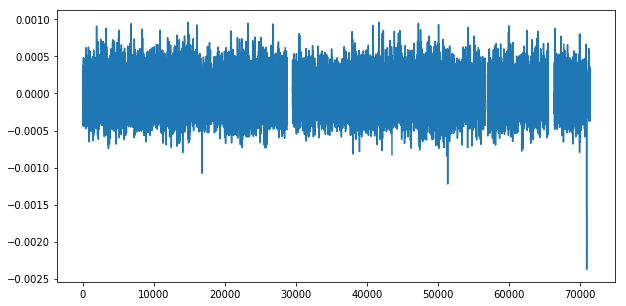

In [27]:
plt.figure(figsize=(10,5))
plt.plot(raw_list[44])
plt.show()

Cantidad de tramos:  842
Largo promedio entre tramos:  76.4809976247031
Largo mediana entre tramos:  74.0
Largo min entre tramos:  1
Largo max entre tramos:  149
Log-likehood con 15  estados del conjunto de entrenamiento 71277.51080367019


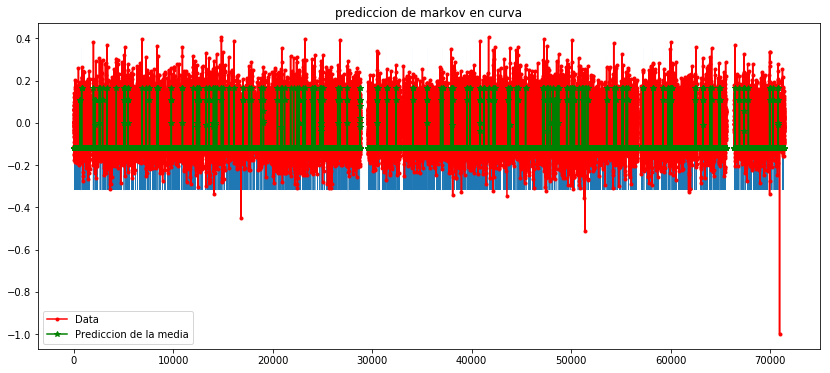

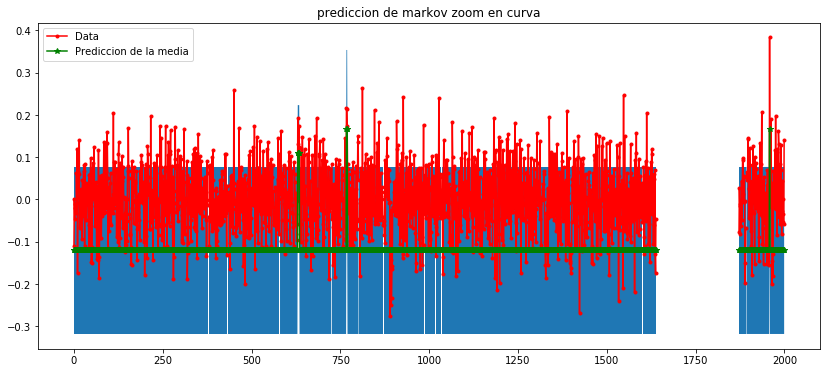

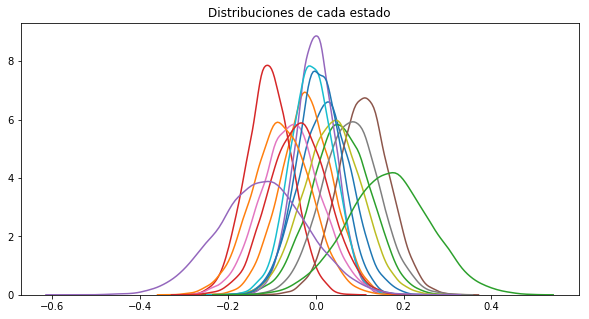

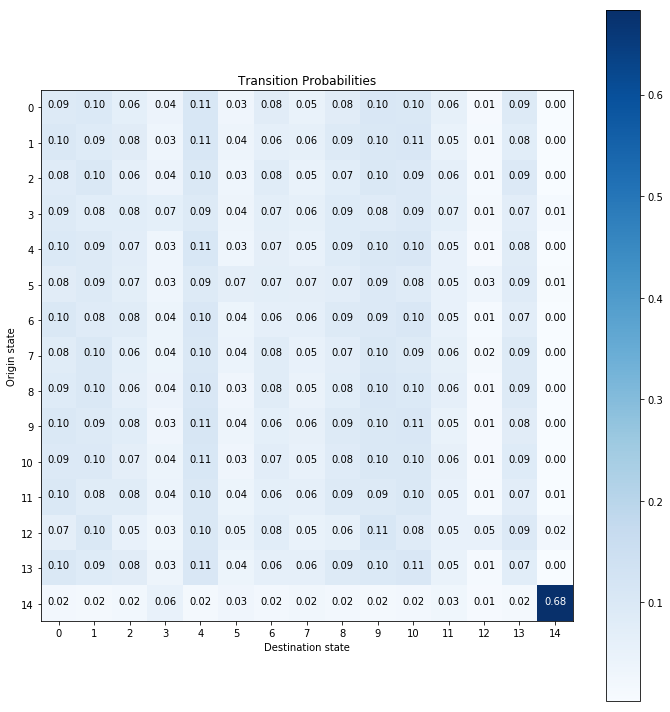

Log-likehood con 15  estados del conjunto de entrenamiento 71277.4030989977


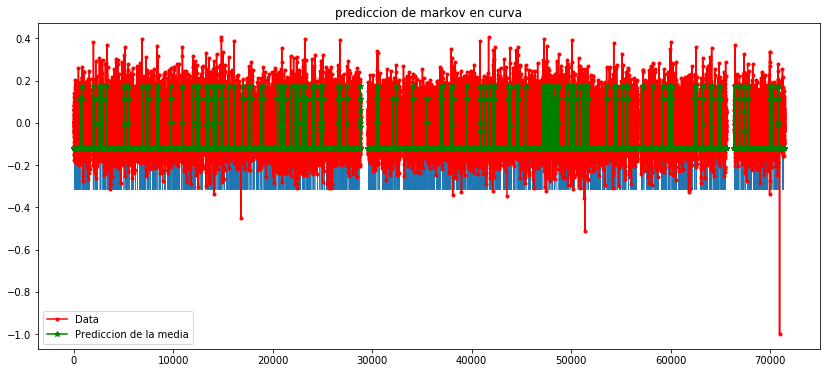

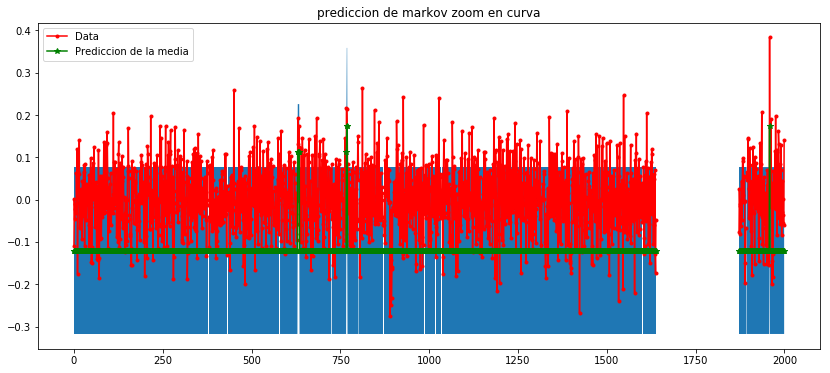

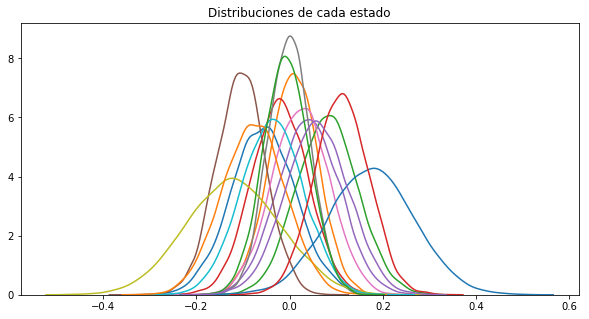

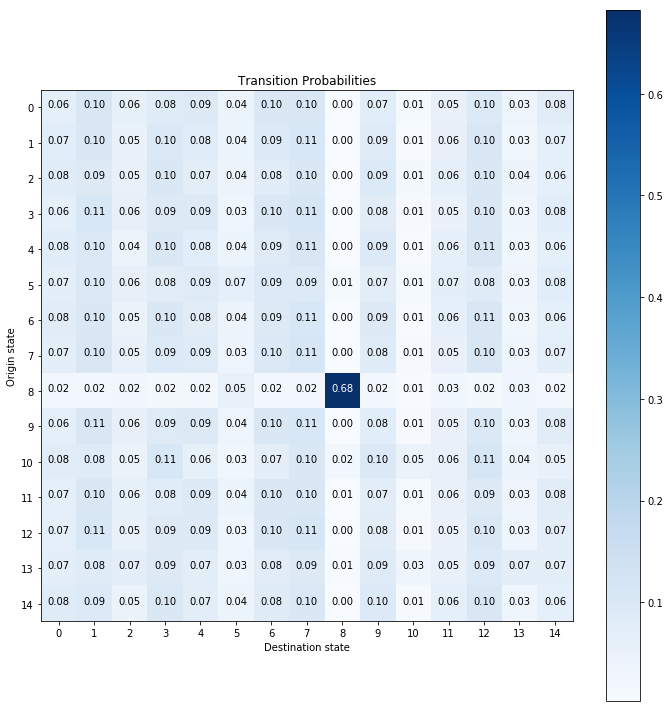

Log-likehood con 15  estados del conjunto de entrenamiento 71276.356959318


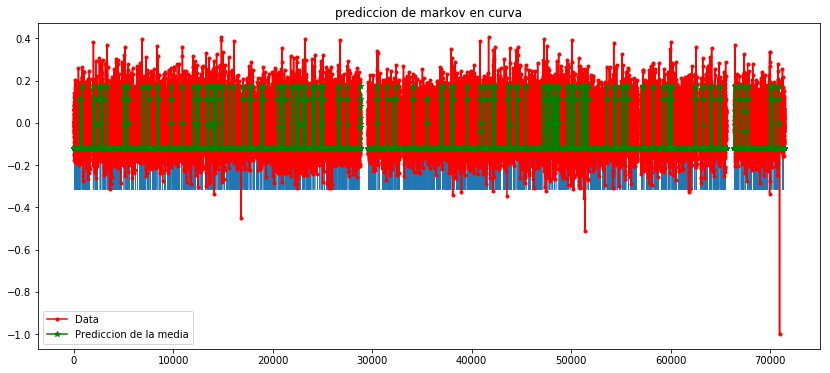

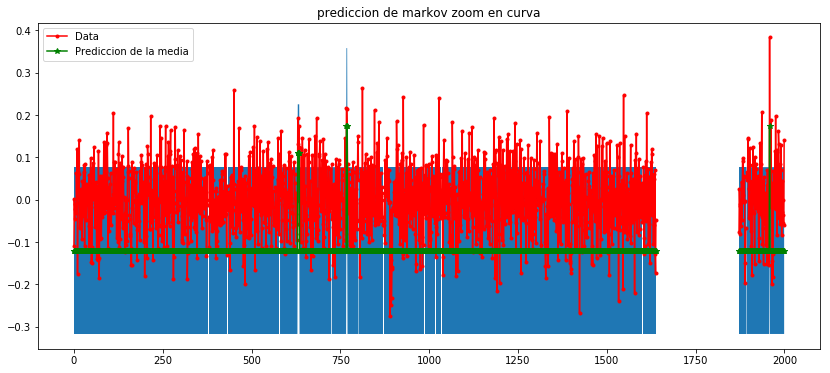

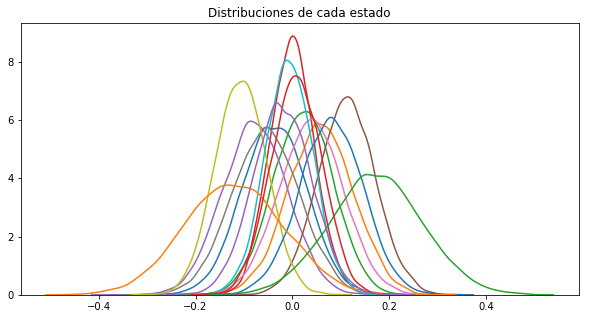

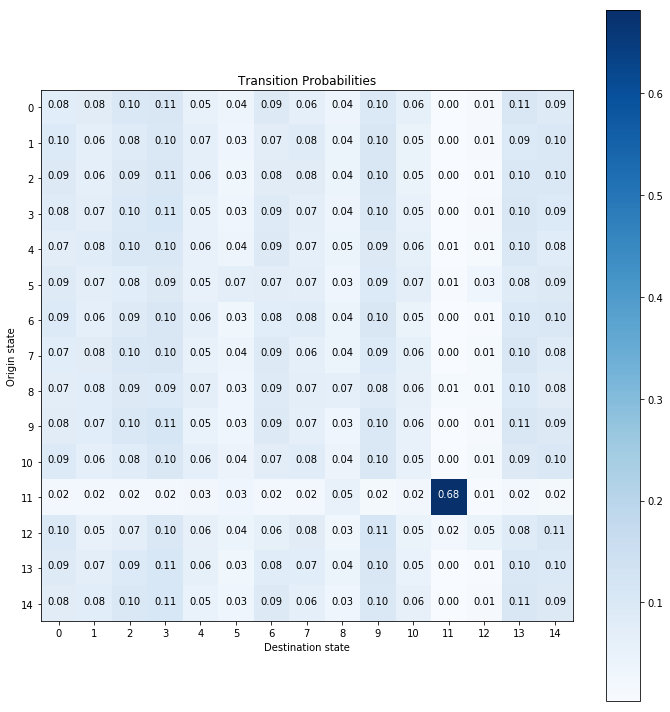

Log-likehood con 15  estados del conjunto de entrenamiento 71277.16644170621


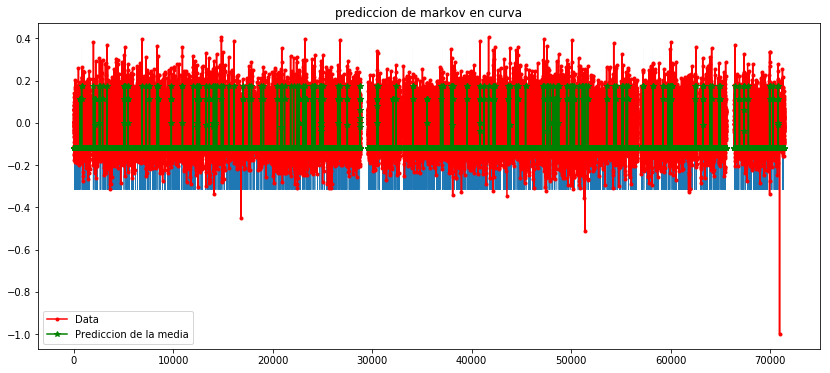

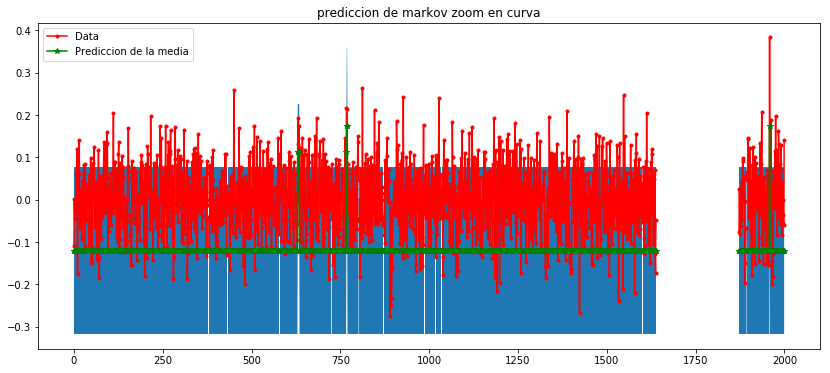

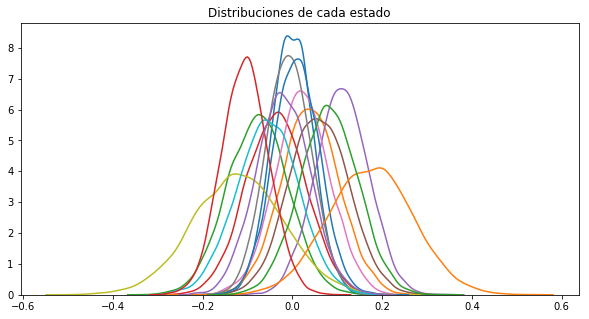

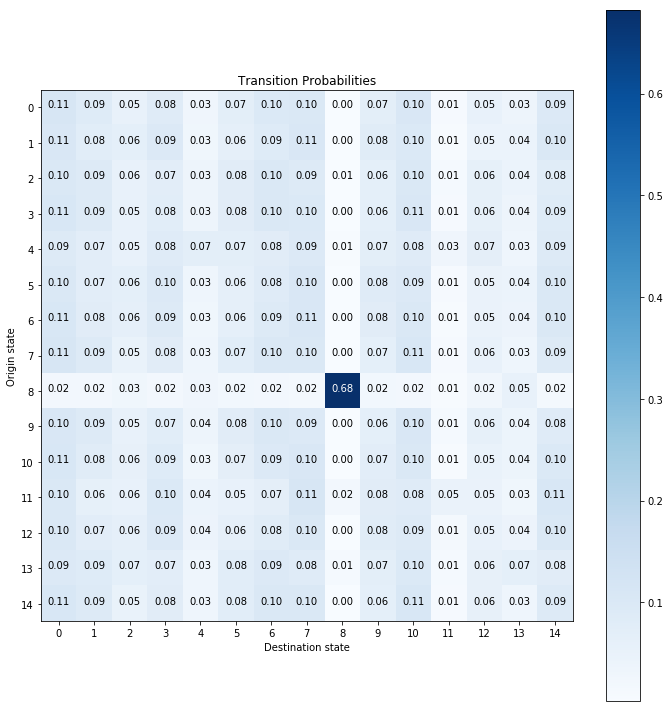

Log-likehood con 15  estados del conjunto de entrenamiento 71277.49124764853


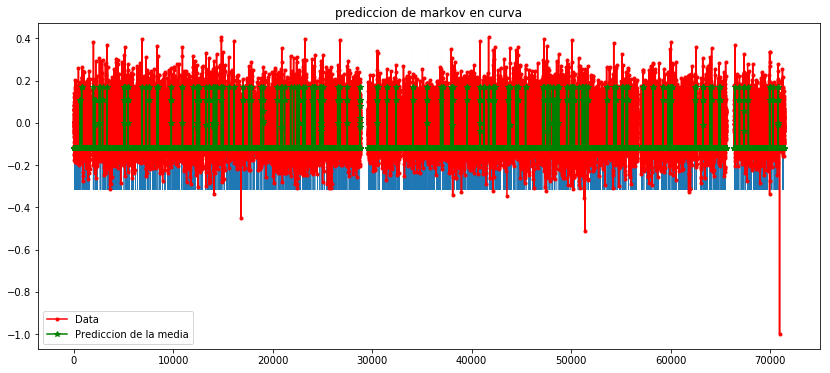

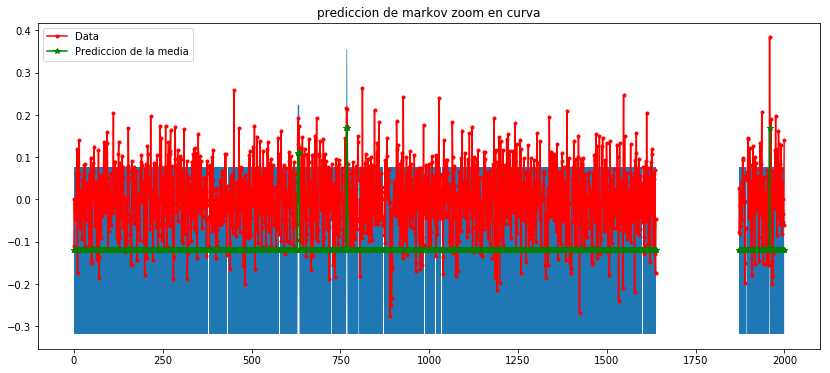

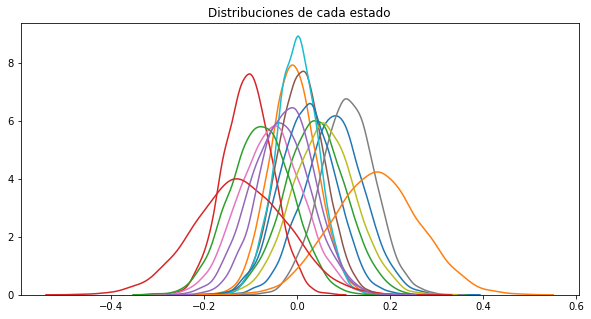

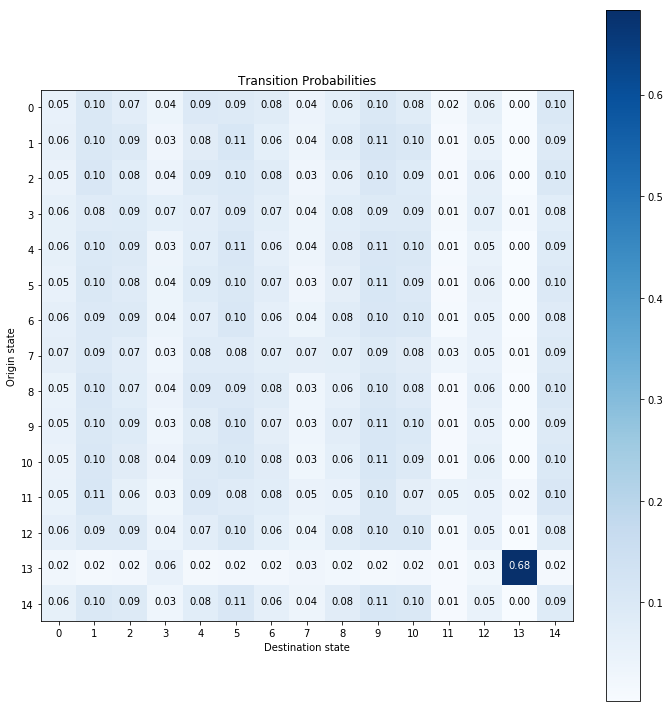

In [29]:
lc_our_detrend = raw_list[44]
lc_wind_nan = []
lengths = []
sublist = []
for value in lc_our_detrend:
    if np.isnan(value) and len(sublist) != 0:
        lc_wind_nan.append(np.asarray(sublist))
        lengths.append(len(sublist))
        sublist = []
    elif np.isnan(value) and len(sublist) == 0:
        continue
    else: 
        sublist.append(value) 
if len(sublist) != 0:      ####IMOPRTANTEEEEEEEEEEEEEEEEEEEEEEEEEE
    lc_wind_nan.append(np.asarray(sublist))
    lengths.append(len(sublist))
lc_wind_nan = np.asarray(lc_wind_nan)   
lengths = np.asarray(lengths)   

print("Cantidad de tramos: ",len(lengths))
print("Largo promedio entre tramos: ", np.mean(lengths))
print("Largo mediana entre tramos: ", np.median(lengths))
print("Largo min entre tramos: ", np.min(lengths))
print("Largo max entre tramos: ", np.max(lengths))

lc_wind_nan = np.concatenate(lc_wind_nan).reshape(-1,1)
lc_wind_nan = lc_wind_nan/np.abs(np.min(lc_wind_nan)) 

for i in range(5):
    n_sta = 15
    markov_model = hmm.GaussianHMM(n_components=n_sta, n_iter=50)
    markov_model.fit(lc_wind_nan , lengths)

    print("Log-likehood con",n_sta," estados del conjunto de entrenamiento",markov_model.score(lc_wind_nan)) 

    plot_model_and_data(lc_wind_nan, markov_model, p_n=2000, real_lc= lc_our_detrend) 

    plt.figure(figsize=(10,5))
    for i in range(n_sta):
        r = norm(markov_model.means_[i], np.sqrt( markov_model.covars_[i,0])).rvs(10000)
        sns.distplot(r,kde=True, hist=False)

    plt.title("Distribuciones de cada estado")
    plt.show()
    plot_state_matrix(markov_model.transmat_,np.arange(n_sta))
    plt.show()

Cantidad de tramos:  842
Largo promedio entre tramos:  76.4809976247031
Largo mediana entre tramos:  74.0
Largo min entre tramos:  1
Largo max entre tramos:  149
Log-likehood con 5  estados del conjunto de entrenamiento 71087.14087352568


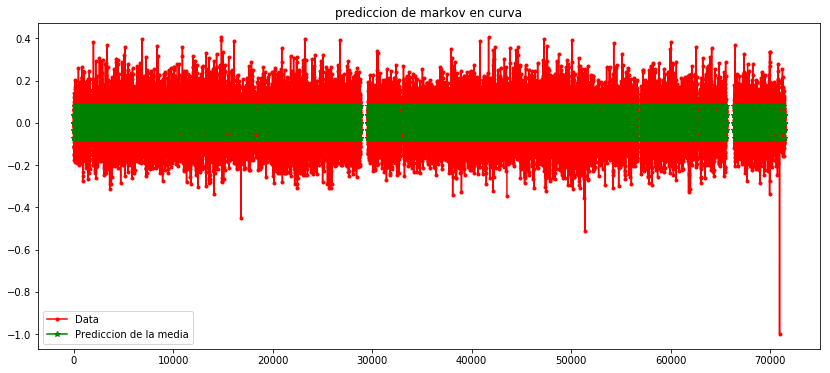

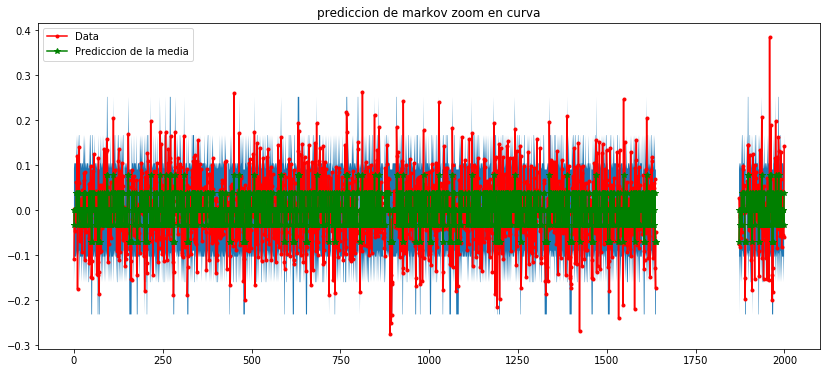

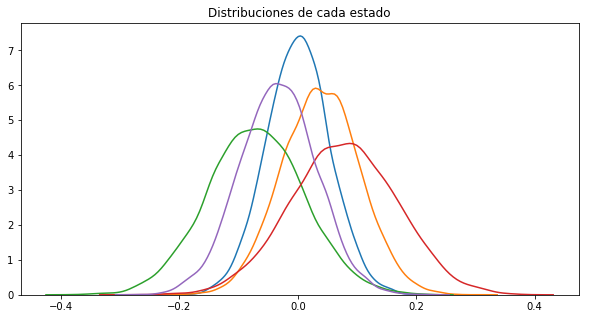

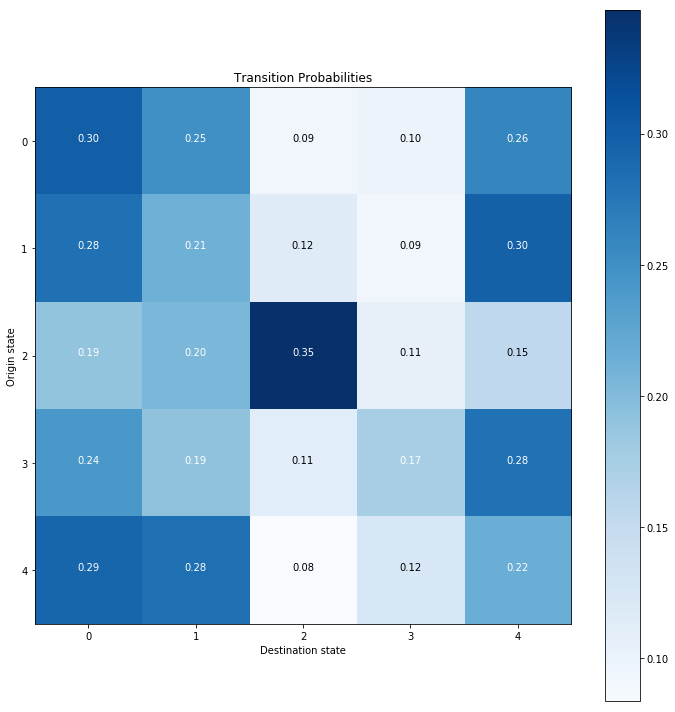

Log-likehood con 6  estados del conjunto de entrenamiento 71111.36192887898


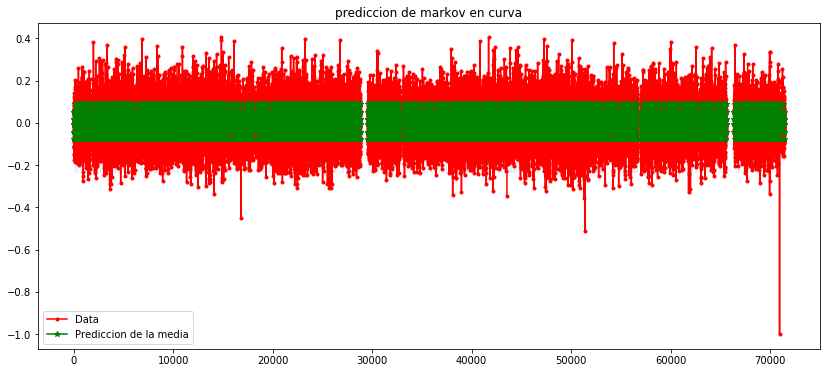

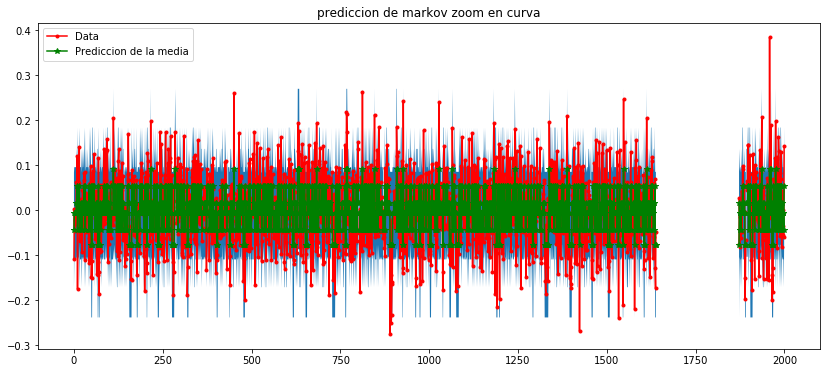

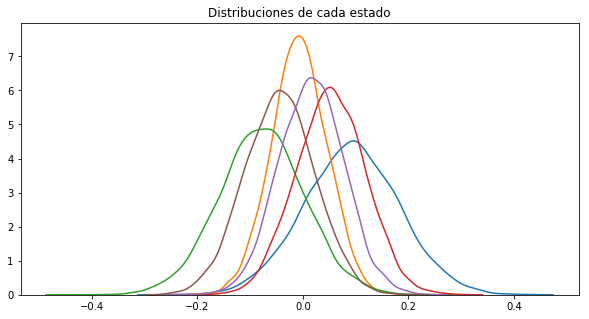

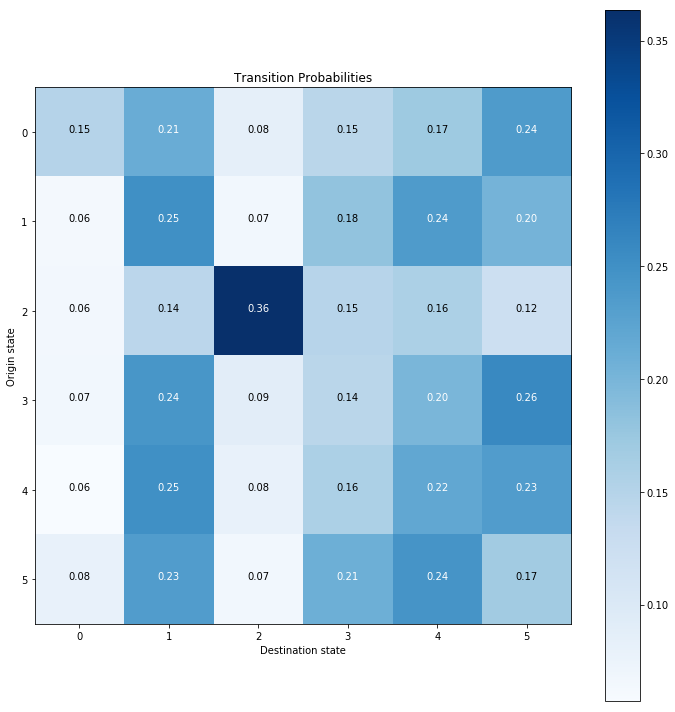

Log-likehood con 7  estados del conjunto de entrenamiento 71173.35445977964


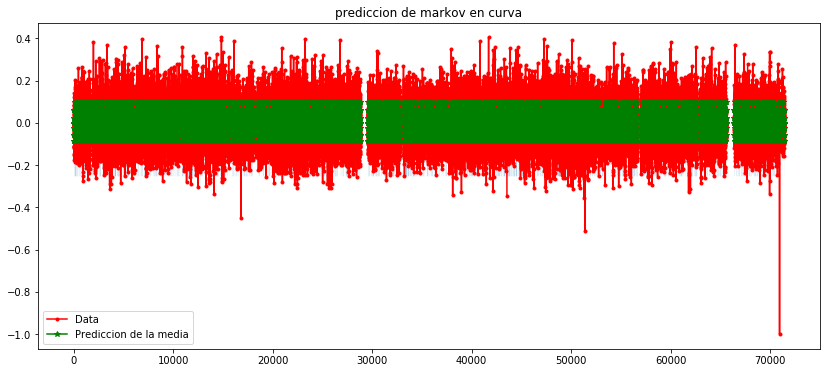

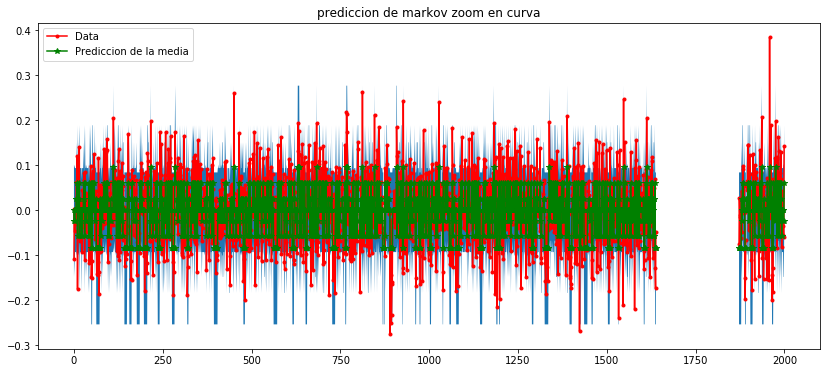

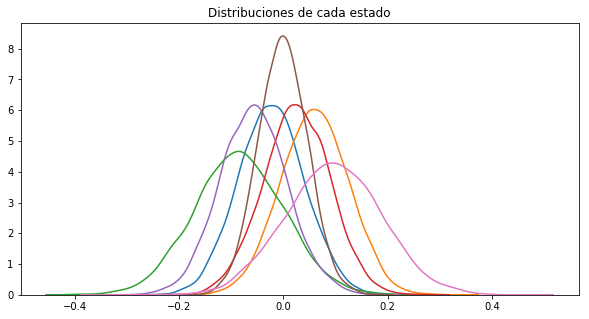

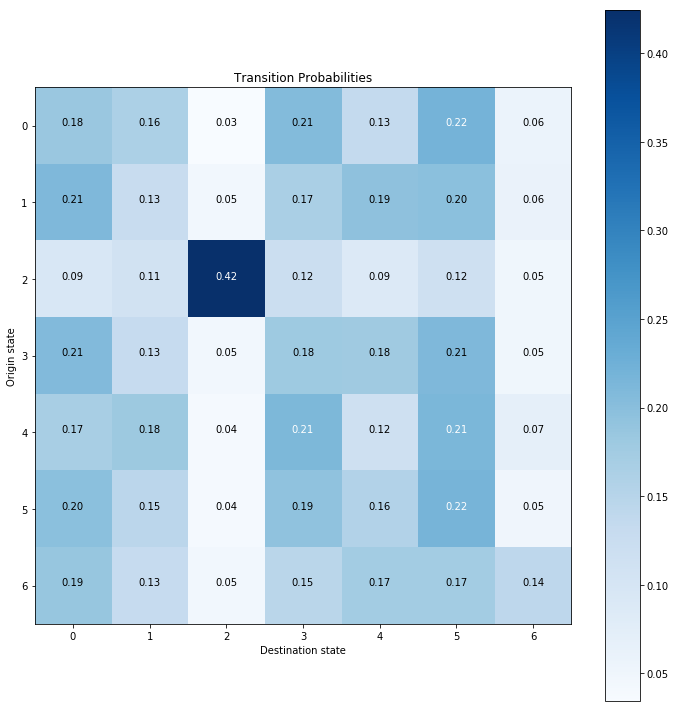

Log-likehood con 8  estados del conjunto de entrenamiento 71191.70799411266


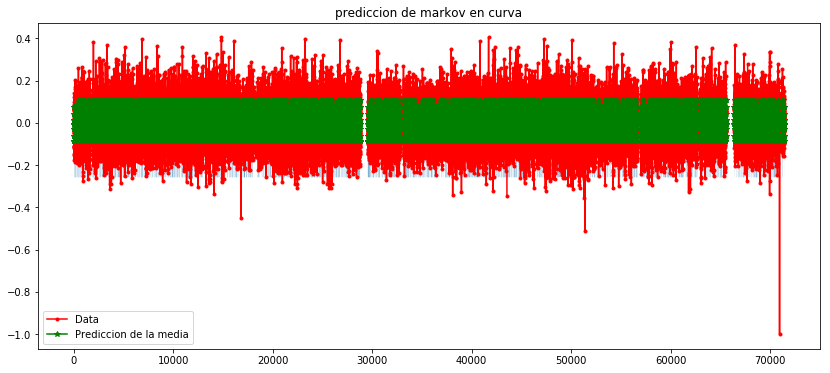

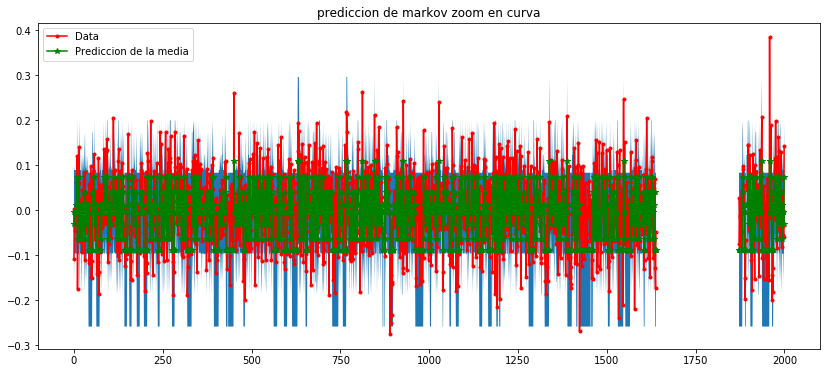

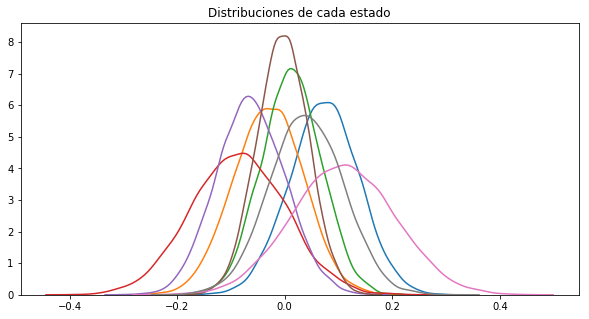

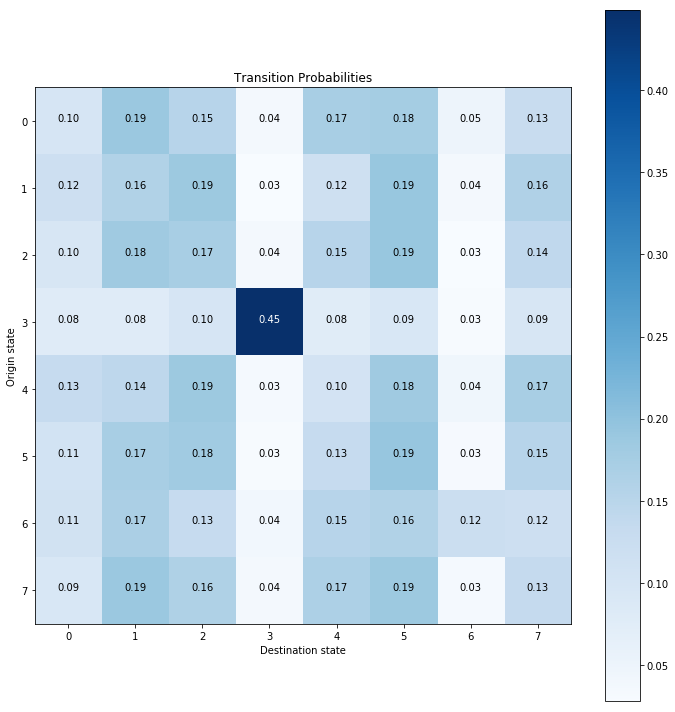

Log-likehood con 9  estados del conjunto de entrenamiento 71234.48158278776


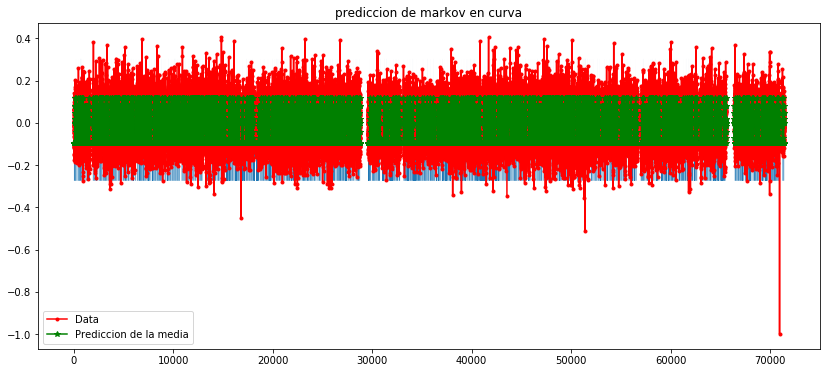

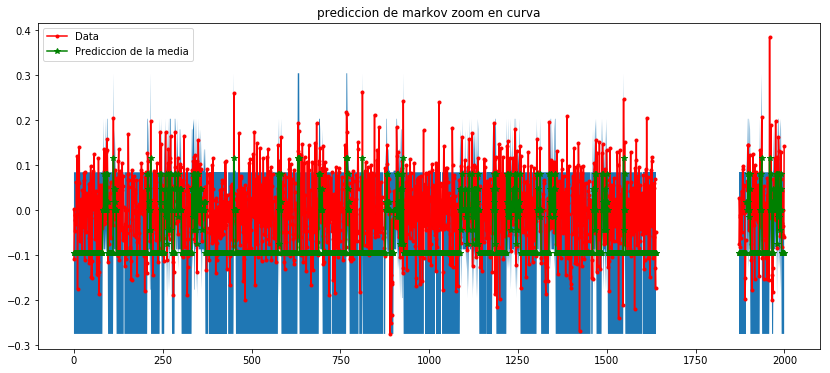

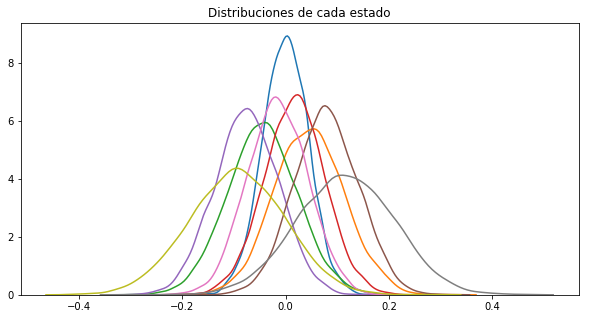

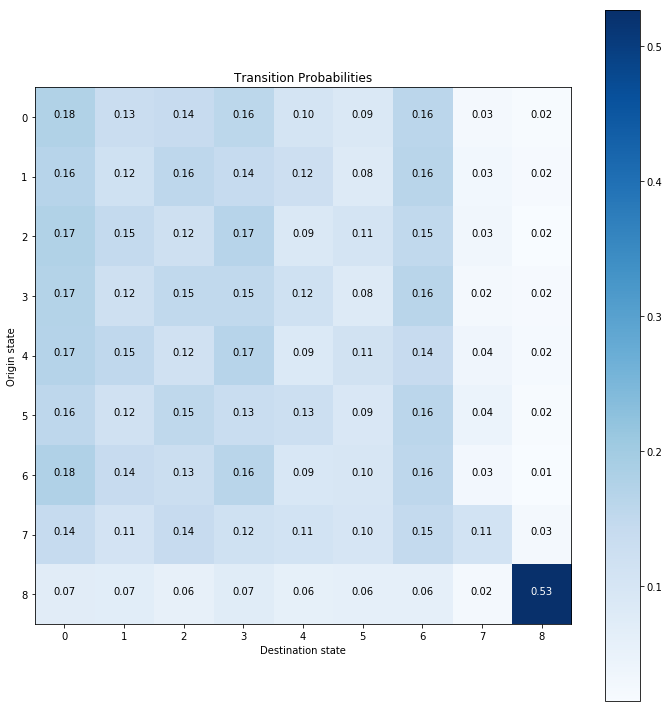

Log-likehood con 10  estados del conjunto de entrenamiento 71242.67236530685


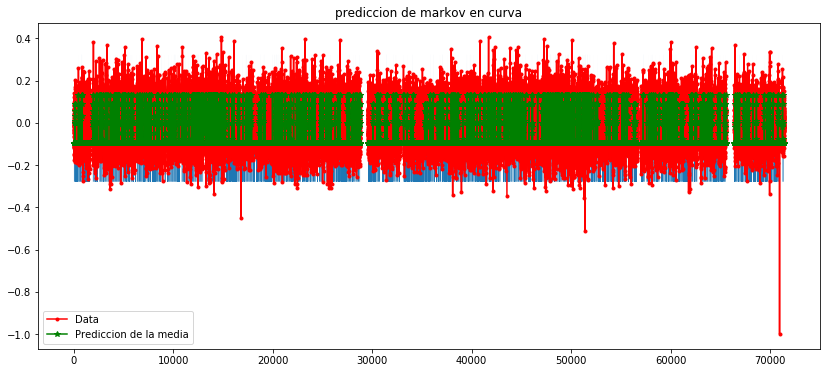

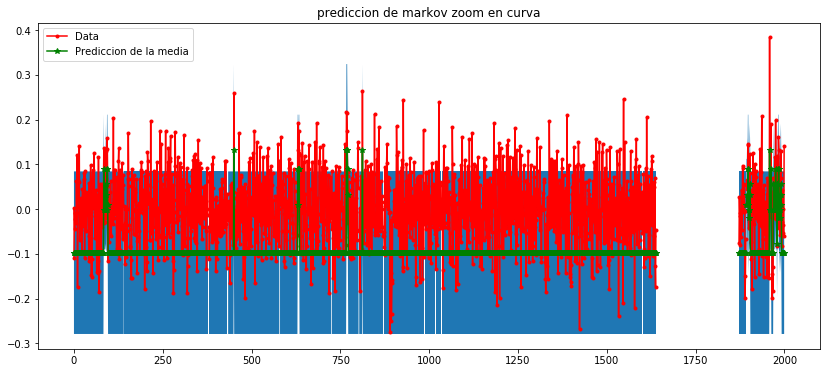

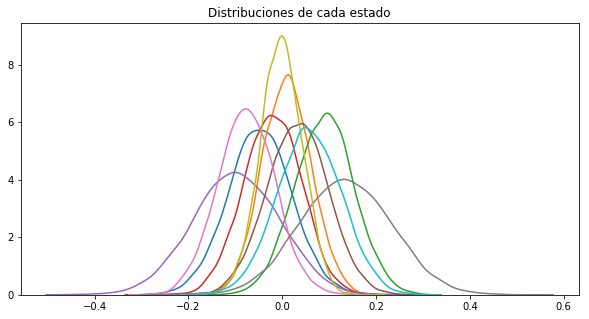

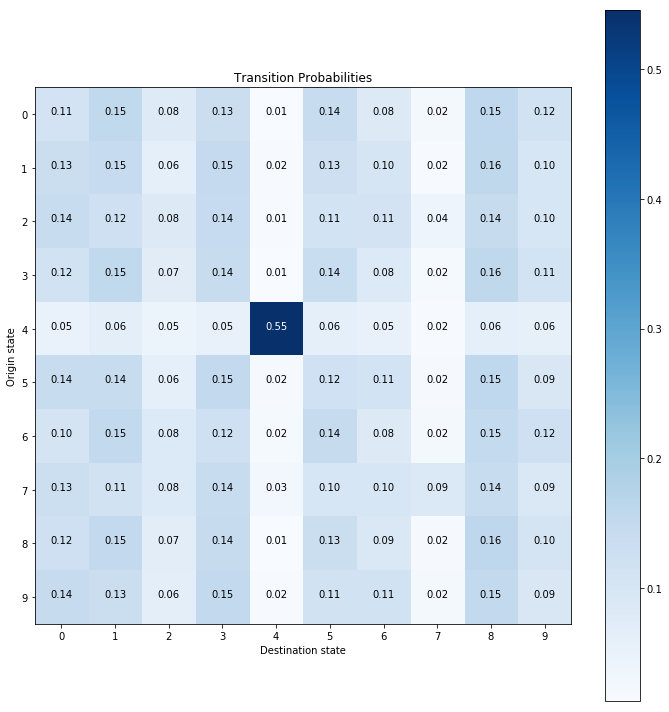

Log-likehood con 11  estados del conjunto de entrenamiento 71266.57498323769


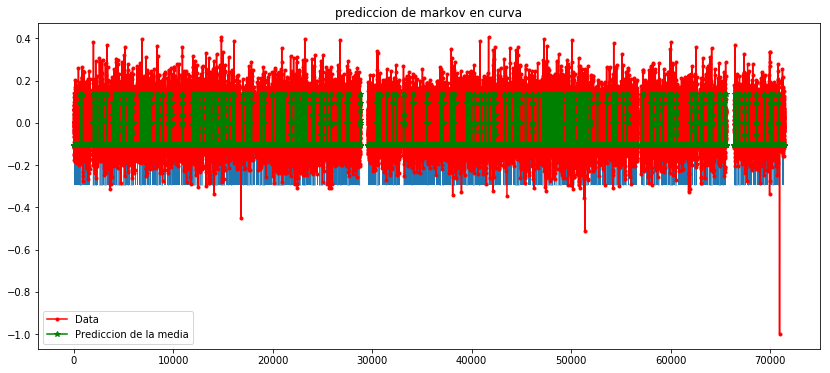

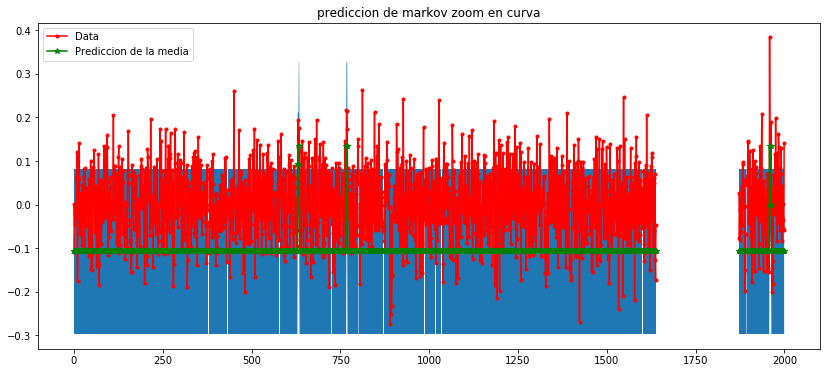

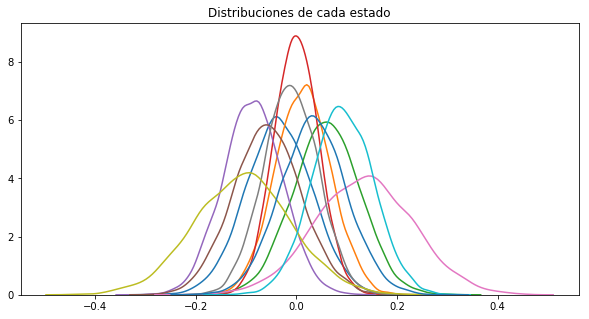

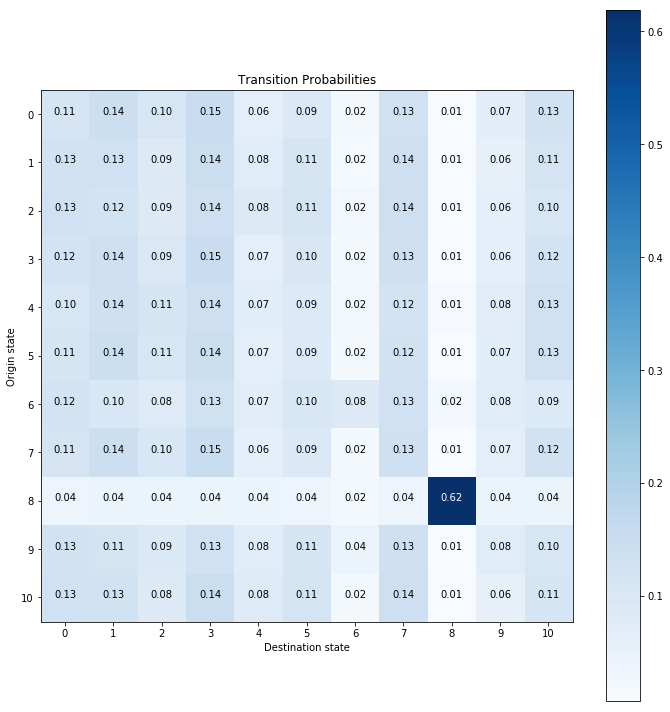

Log-likehood con 12  estados del conjunto de entrenamiento 71267.1765617474


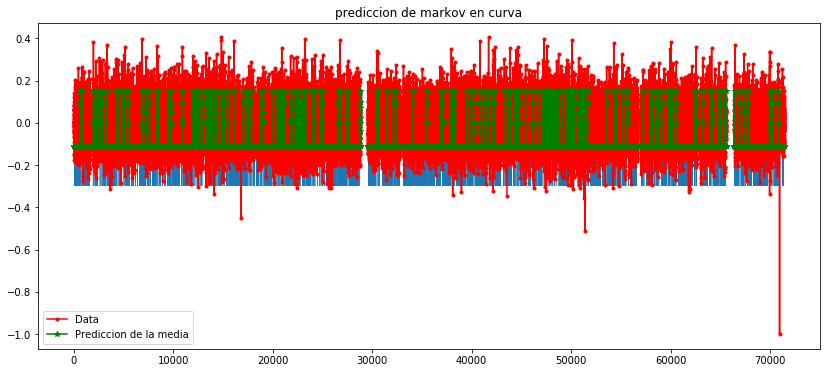

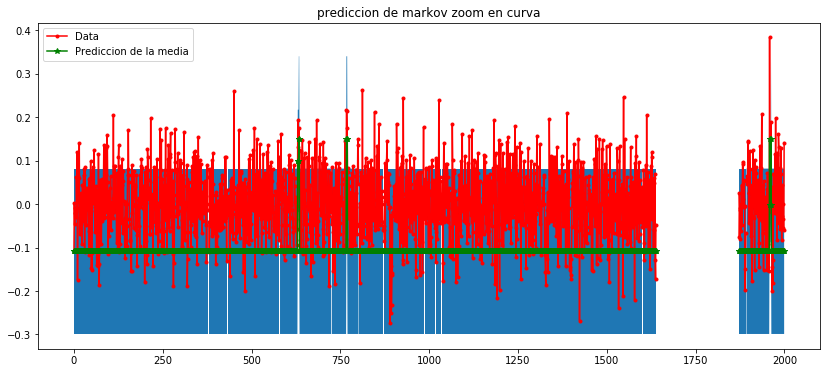

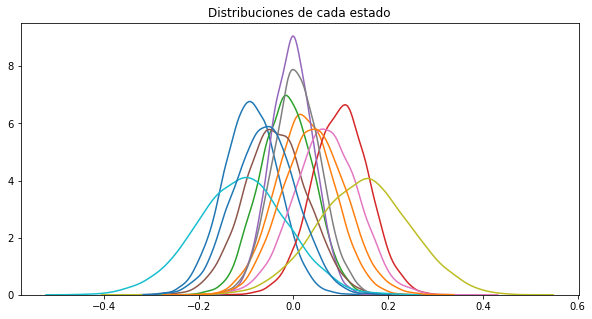

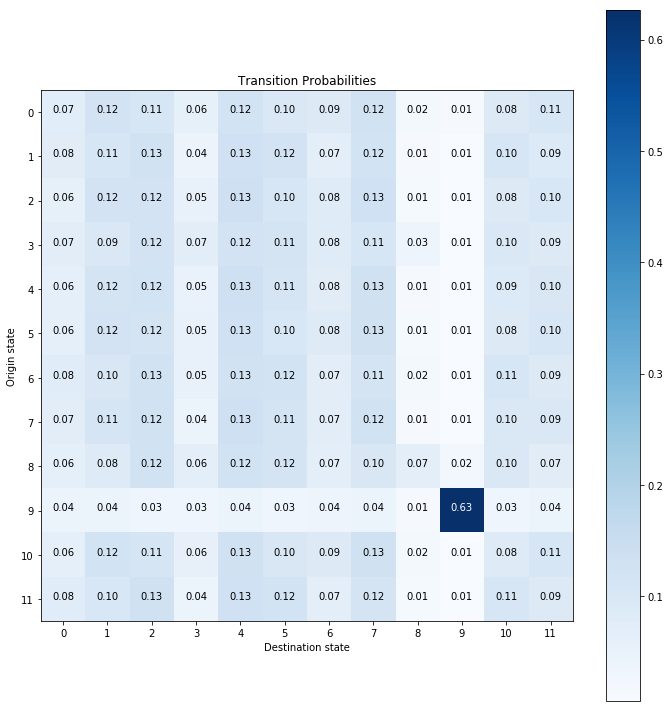

Log-likehood con 13  estados del conjunto de entrenamiento 71271.20793529536


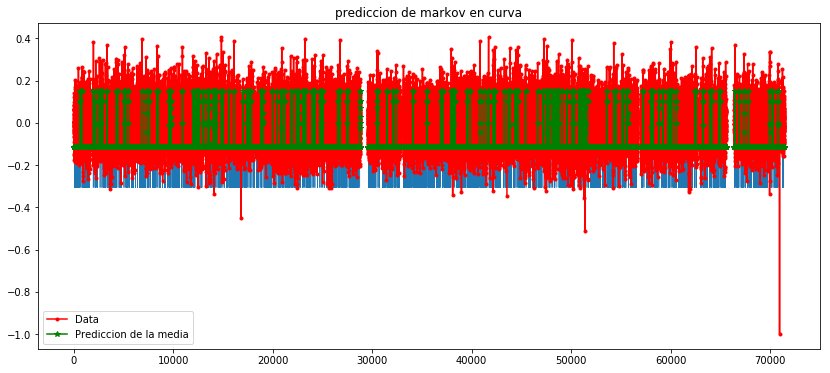

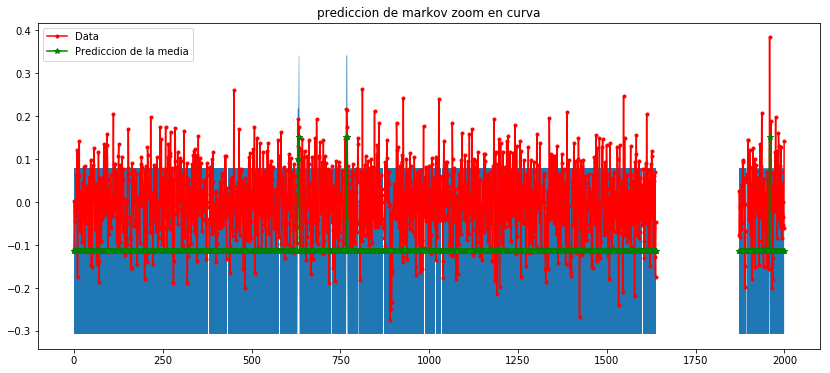

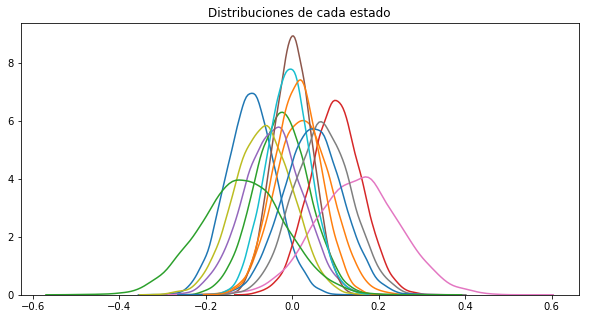

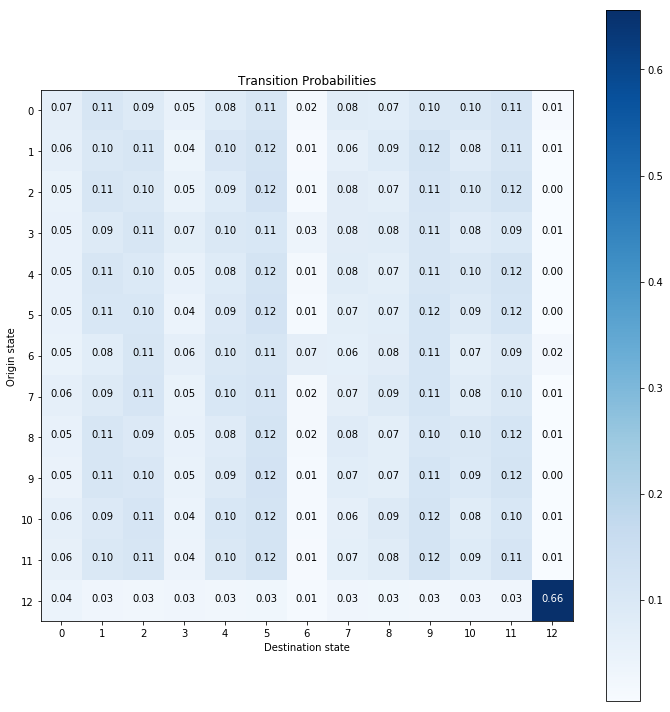

Log-likehood con 14  estados del conjunto de entrenamiento 71273.48103565298


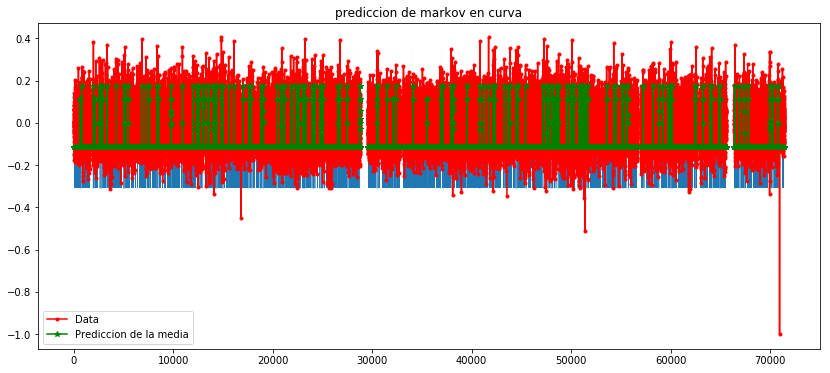

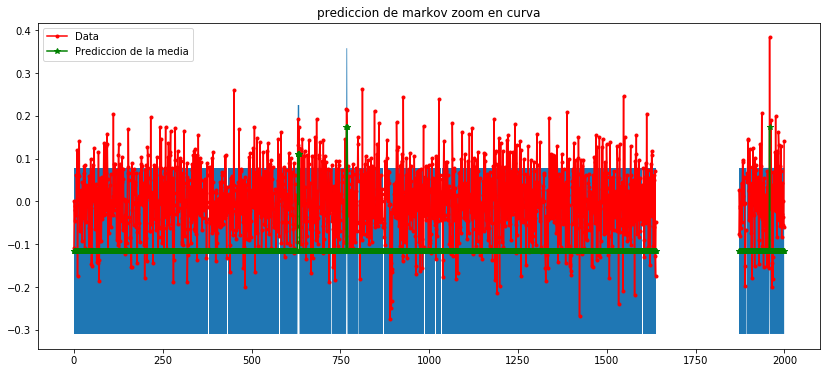

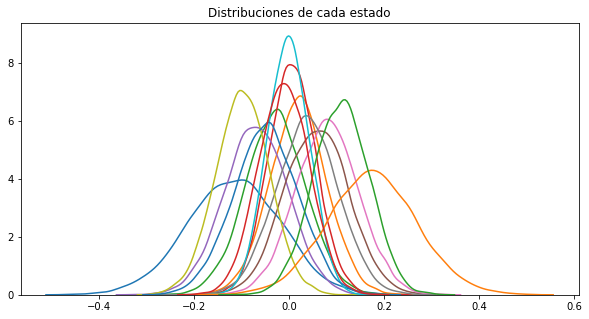

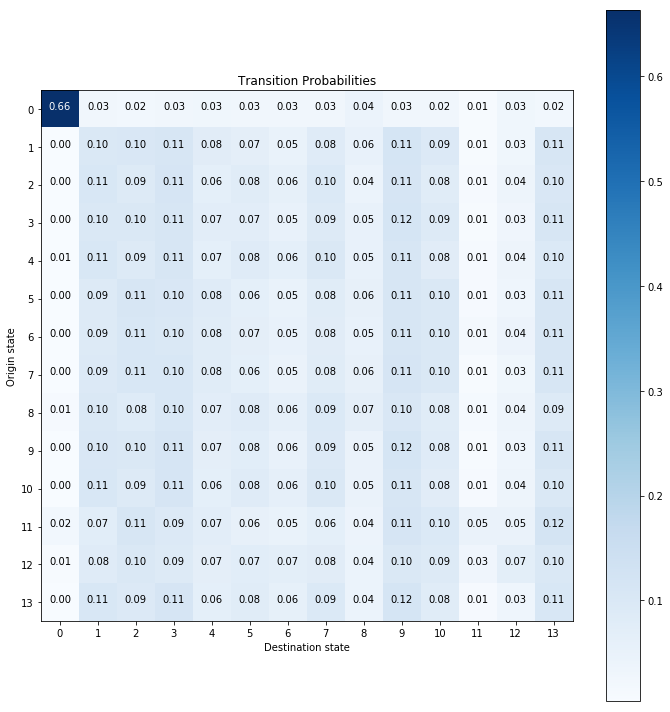

Log-likehood con 15  estados del conjunto de entrenamiento 71277.88423460127


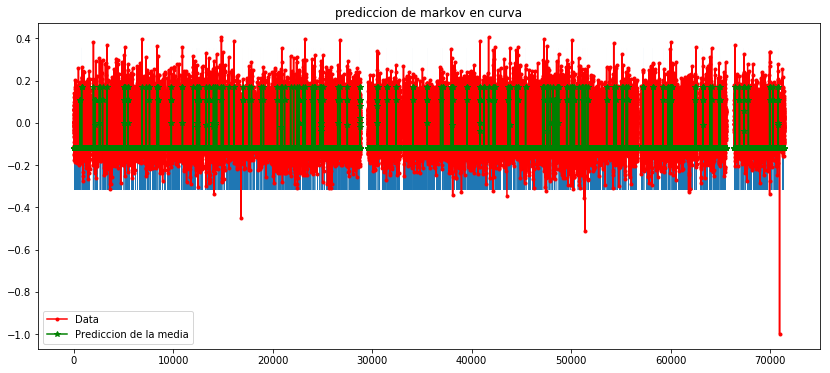

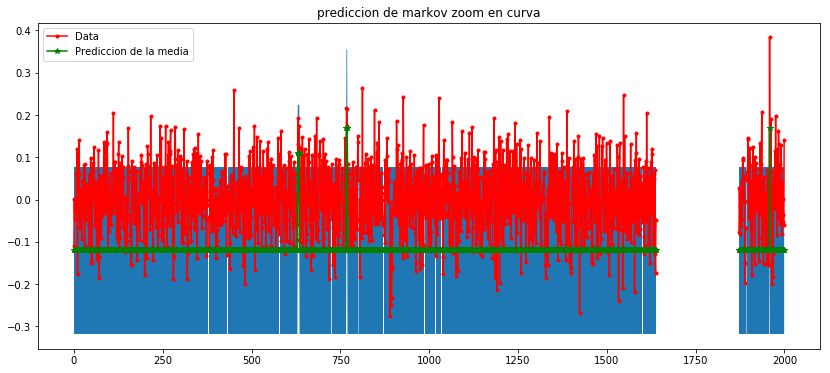

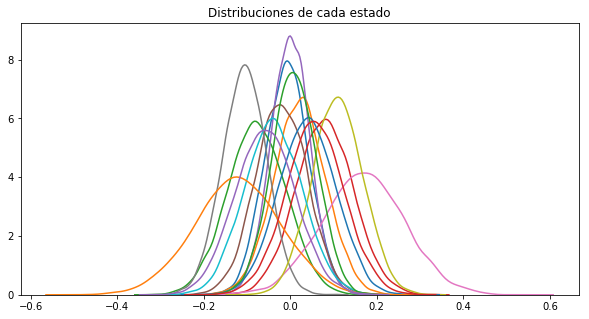

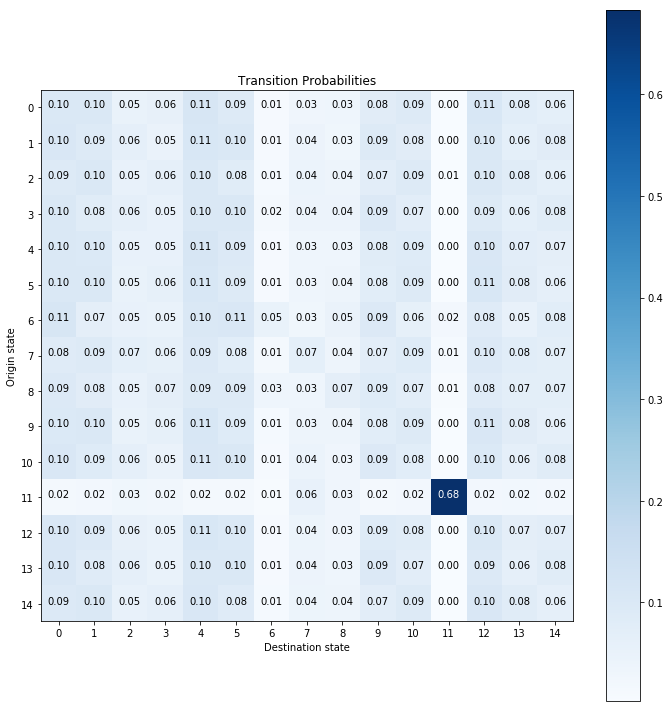

In [28]:
lc_our_detrend = raw_list[44]
lc_wind_nan = []
lengths = []
sublist = []
for value in lc_our_detrend:
    if np.isnan(value) and len(sublist) != 0:
        lc_wind_nan.append(np.asarray(sublist))
        lengths.append(len(sublist))
        sublist = []
    elif np.isnan(value) and len(sublist) == 0:
        continue
    else: 
        sublist.append(value) 
if len(sublist) != 0:      ####IMOPRTANTEEEEEEEEEEEEEEEEEEEEEEEEEE
    lc_wind_nan.append(np.asarray(sublist))
    lengths.append(len(sublist))
lc_wind_nan = np.asarray(lc_wind_nan)   
lengths = np.asarray(lengths)   

print("Cantidad de tramos: ",len(lengths))
print("Largo promedio entre tramos: ", np.mean(lengths))
print("Largo mediana entre tramos: ", np.median(lengths))
print("Largo min entre tramos: ", np.min(lengths))
print("Largo max entre tramos: ", np.max(lengths))

lc_wind_nan = np.concatenate(lc_wind_nan).reshape(-1,1)
lc_wind_nan = lc_wind_nan/np.abs(np.min(lc_wind_nan)) 

for n_sta in [5,6,7,8,9,10,11,12,13,14,15]:
    markov_model = hmm.GaussianHMM(n_components=n_sta, n_iter=50)
    markov_model.fit(lc_wind_nan , lengths)

    print("Log-likehood con",n_sta," estados del conjunto de entrenamiento",markov_model.score(lc_wind_nan)) 

    plot_model_and_data(lc_wind_nan, markov_model, p_n=2000, real_lc= lc_our_detrend) 

    plt.figure(figsize=(10,5))
    for i in range(n_sta):
        r = norm(markov_model.means_[i], np.sqrt( markov_model.covars_[i,0])).rvs(10000)
        sns.distplot(r,kde=True, hist=False)

    plt.title("Distribuciones de cada estado")
    plt.show()
    plot_state_matrix(markov_model.transmat_,np.arange(n_sta))
    plt.show()

In [ ]:
lc_our_detrend = 
lc_wind_nan = []
lengths = []
sublist = []
for value in lc_our_detrend:
    if np.isnan(value) and len(sublist) != 0:
        lc_wind_nan.append(np.asarray(sublist))
        lengths.append(len(sublist))
        sublist = []
    elif np.isnan(value) and len(sublist) == 0:
        continue
    else: 
        sublist.append(value) 
if len(sublist) != 0:      ####IMOPRTANTEEEEEEEEEEEEEEEEEEEEEEEEEE
    lc_wind_nan.append(np.asarray(sublist))
    lengths.append(len(sublist))
lc_wind_nan = np.asarray(lc_wind_nan)   
lengths = np.asarray(lengths)   

print("Cantidad de tramos: ",len(lengths))
print("Largo promedio entre tramos: ", np.mean(lengths))
print("Largo mediana entre tramos: ", np.median(lengths))
print("Largo min entre tramos: ", np.min(lengths))
print("Largo max entre tramos: ", np.max(lengths))

lc_wind_nan = np.concatenate(lc_wind_nan).reshape(-1,1)
lc_wind_nan = lc_wind_nan/np.abs(np.min(lc_wind_nan)) 

n_sta=15
markov_model = hmm.GaussianHMM(n_components=n_sta, n_iter=50)
markov_model.fit(lc_wind_nan , lengths)

print("Log-likehood con",n_sta," estados del conjunto de entrenamiento",markov_model.score(lc_wind_nan)) 

plot_model_and_data(lc_wind_nan, markov_model, p_n=2000, real_lc= lc_our_detrend) 

plt.figure(figsize=(10,5))
for i in range(n_sta):
    r = norm(markov_model.means_[i], np.sqrt( markov_model.covars_[i,0])).rvs(10000)
    sns.distplot(r,kde=True, hist=False)

plt.title("Distribuciones de cada estado")
plt.show()
plot_state_matrix(markov_model.transmat_,np.arange(n_sta))
plt.show()

In [ ]:
n_state = [5,10,15,25,35]
for n_sta in n_state:
    markov_model = hmm.GaussianHMM(n_components=n_sta, n_iter=50)
    markov_model.fit(new_lc)
    print("Log-likehood con",n_sta," estados del conjunto de entrenamiento",markov_model.score(new_lc)) 
    
    X_state = markov_model.predict(new_lc) #predice el estado, no el valor 
    plt.figure(figsize=(14,5))
    plt.plot(new_lc,'r.-',label="Data") #-- here put train or val plt.legend() plt.show()
    plt.fill_between(np.arange(np.asarray(new_lc).shape[0]),
                     markov_model.means_[X_state][:,0]-1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0],
                     markov_model.means_[X_state][:,0]+1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0]) 
    plt.plot(markov_model.means_[X_state][:,0],'g*-',label="Prediccion de la media") 
    plt.legend()
    plt.title("prediccion de markov en toda curva")
    plt.show()
    
    plt.figure(figsize=(14,5))
    plt.plot(new_lc[:2000],'r.-',label="Data") #-- here put train or val plt.legend() plt.show()
    plt.fill_between(np.arange(2000),
                     markov_model.means_[X_state[:2000]][:,0]-1.96*np.sqrt(markov_model.covars_[X_state[:2000]])[:,0,0],
                     markov_model.means_[X_state[:2000]][:,0]+1.96*np.sqrt(markov_model.covars_[X_state[:2000]])[:,0,0]) 
    plt.plot(markov_model.means_[X_state[:2000]][:,0],'g*-',label="Prediccion de la media") 
    plt.legend()
    plt.title("prediccion de markov en zoom de curva")
    plt.show()
    
    plt.figure(figsize=(10,5))
    for i in range(n_sta):
        r = norm(markov_model.means_[i], np.sqrt( markov_model.covars_[i,0])).rvs(10000)
        sns.distplot(r,kde=True, hist=False)

    plt.title("Distribuciones de cada estado")
    plt.show()
    plot_state_matrix(markov_model.transmat_,np.arange(n_sta))
    plt.show()